In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
import seaborn as sn
import datetime as dt
import pylab as pl
import urllib.request
from urllib.request import urlretrieve
import zipfile
import statsmodels as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
%pylab inline

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
pd.set_option('display.max_columns', 500)

# SECTION 1. 311 DATA MUNGING 

In [3]:
# Get the data form the open data website
# Just run if you do not have already one of the clean datasets, it takes a while to get the data
df = pd.read_csv("https://data.cityofnewyork.us/api/views/erm2-nwe9/rows.csv?accessType=DOWNLOAD")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8,17,31,32,33,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#Pulling takes a lot of time, so use the following code to just read from csv.
#df = pd.read_csv("311_Service_Requests_from_2010_to_Present.csv")

In [5]:
# Visualize the first 5 observations of the data
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,29509010,12/15/2014 12:47:20 PM,01/30/2015 09:27:39 AM,DOT,Department of Transportation,Curb Condition,Broken Curb,Sidewalk,11234,1844 EAST 34 STREET,EAST 34 STREET,AVENUE R,FILLMORE AVENUE,NaN,NaN,ADDRESS,BROOKLYN,NaN,NaN,Closed,01/14/2015 12:47:20 PM,The Department of Transportation will inspect ...,01/30/2015 09:27:40 AM,18 BROOKLYN,3.084770e+09,BROOKLYN,1002139.0,161989.0,PHONE,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.611281,-73.935570,"(40.611280713381426, -73.9355699152107)"
1,29509023,12/15/2014 06:23:00 AM,12/18/2014 09:00:00 AM,DEP,Department of Environmental Protection,Noise,Noise: Manufacturing Noise (NK1),NaN,11211,398 MORGAN AVENUE,MORGAN AVENUE,SKILLMAN AVE,JACKSON ST,NaN,NaN,ADDRESS,BROOKLYN,NaN,NaN,Closed,NaN,The Department of Environmental Protection det...,12/18/2014 09:00:00 AM,01 BROOKLYN,3.028870e+09,BROOKLYN,1001779.0,200763.0,PHONE,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.717707,-73.936766,"(40.71770742395871, -73.93676570169862)"
2,29509024,12/15/2014 02:13:00 PM,12/30/2014 08:56:00 AM,DEP,Department of Environmental Protection,Water Quality,"Taste/Odor, Sewer (QA5)",NaN,10031,706 RIVERSIDE DRIVE,RIVERSIDE DRIVE,W 147 ST,W 148 ST,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,NaN,The Department of Environmental Protection req...,12/30/2014 08:56:00 AM,09 MANHATTAN,1.020948e+09,MANHATTAN,997939.0,241205.0,PHONE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.828717,-73.950536,"(40.82871687088971, -73.9505357732226)"
3,29509025,12/15/2014 03:03:54 PM,12/16/2014 10:18:46 AM,DOT,Department of Transportation,Street Condition,Blocked - Construction,Street,10307,NaN,NaN,NaN,NaN,BEDELL AVENUE,HYLAN BOULEVARD,INTERSECTION,STATEN ISLAND,NaN,NaN,Closed,12/25/2014 03:03:54 PM,The Department of Transportation inspected the...,12/16/2014 10:18:46 AM,03 STATEN ISLAND,NaN,STATEN ISLAND,919439.0,123988.0,PHONE,Unspecified,STATEN ISLAND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.506757,-74.233062,"(40.506756694980204, -74.2330624883556)"
4,29509042,12/15/2014 08:04:55 AM,01/12/2015 07:40:40 AM,DPR,Department of Parks and Recreation,Dead Tree,Dead/Dying Tree,Street,10472,1136 TAYLOR AVENUE,TAYLOR AVENUE,WATSON AVENUE,GLEASON AVENUE,NaN,NaN,ADDRESS,BRONX,NaN,NaN,Closed,01/19/2015 01:47:38 PM,The Department of Parks and Recreation has cor...,01/12/2015 07:40:40 AM,09 BRONX,2.037550e+09,BRONX,1021698.0,241258.0,PHONE,Unspecified,BRONX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.828794,-73.864684,"(40.828793561001596, -73.86468411588999)"


In [6]:
# Look at the shape of the data
df.shape

(9347262, 41)

We can see how big the entire dataset is! We need some cleaning. First just get the years we are interested in (2013, 2014 and 2015) then get rid of some columns we really do not need, then just keep the Noise complaints that are the main focus of our work.

In [7]:
# Visualize all the columns the data has
df.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [8]:
# Visualize the complaint types so that we get only noise
df["Complaint Type"].unique()

array(['Curb Condition', 'Noise', 'Water Quality', 'Street Condition',
       'Dead Tree', 'Street Sign - Damaged', 'New Tree Request',
       'Graffiti', 'HEAT/HOT WATER', 'Vacant Lot', 'Taxi Complaint',
       'Noise - Commercial', 'Industrial Waste', 'Hazardous Materials',
       'Noise - Vehicle', 'Maintenance or Facility', 'Housing Options',
       'Animal Abuse', 'Construction', 'DOF Property - Payment Issue',
       'PAINT/PLASTER', 'Illegal Parking', 'Sanitation Condition',
       'Air Quality', 'Derelict Vehicle', 'Traffic', 'Homeless Encampment',
       'Dirty Conditions', 'Indoor Air Quality', 'Noise - Residential',
       'Blocked Driveway', 'Consumer Complaint', 'Sewer',
       'Noise - Street/Sidewalk', 'Non-Emergency Police Matter',
       'Homeless Person Assistance', 'DPR Internal', 'Sidewalk Condition',
       'Water System', 'Derelict Vehicles',
       'DOF Property - Reduction Issue', 'Housing - Low Income Senior',
       'DOF Property - Owner Issue', 'PLUMBING', 'D

In [9]:
# Check the variable type of Created Date.
type(df['Created Date'].iloc[1])

str

In [10]:
noise = df[df["Complaint Type"] == "Noise"]

In [11]:
# Convert to date time
noise['Created Date'] = pd.to_datetime(noise['Created Date'])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [12]:
# Set the maximum and minimum dates we want in our dataset
start_date = '01/01/2013'
end_date = '12/31/2015'

noise =  noise[noise["Created Date"]>start_date]
noise =  noise[noise["Created Date"]<end_date]

In [13]:
# See how many observations we dropped
print (df.shape)
print (noise.shape)

(9347262, 41)
(146301, 41)


In [14]:
noise.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [15]:
# We keep only the columns we are interested in
noise = noise[["Unique Key", "Created Date", "Agency", "Agency Name", "Complaint Type", "Descriptor", "Incident Zip", "Community Board", "Borough", "Latitude", "Longitude", "Location"]]



In [16]:
noise.shape

(146301, 12)

In [17]:
# We are only interested in observations we can geo localize so we check if the column has nan values.
noise1 = noise[noise['Location']=="NaN"]

In [18]:
noise.shape

(146301, 12)

In [19]:
noise1.shape

# It doesn't have any NaN values. How great!

(0, 12)

In [20]:
# We save the data as a csv file in case we want to reload it without spending so much time
noise.to_csv('311data.csv')

In [21]:
noise.head()

,Unique Key,Created Date,Agency,Agency Name,Complaint Type,Descriptor,Incident Zip,Community Board,Borough,Latitude,Longitude,Location
1,29509023,2014-12-15 06:23:00,DEP,Department of Environmental Protection,Noise,Noise: Manufacturing Noise (NK1),11211,01 BROOKLYN,BROOKLYN,40.717707,-73.936766,"(40.71770742395871, -73.93676570169862)"
80,29509957,2014-12-15 11:36:00,DEP,Department of Environmental Protection,Noise,Noise: Construction Equipment (NC1),11385,05 QUEENS,QUEENS,40.701778,-73.909948,"(40.70177817226243, -73.9099480819853)"
81,29509958,2014-12-15 14:28:00,DEP,Department of Environmental Protection,Noise,Noise: Jack Hammering (NC2),10010,06 MANHATTAN,MANHATTAN,40.739783,-73.979503,"(40.73978256844563, -73.97950312127165)"
118,29510070,2014-12-15 07:56:00,DEP,Department of Environmental Protection,Noise,"Noise, Barking Dog (NR5)",11367,08 QUEENS,QUEENS,40.731690,-73.820385,"(40.7316900164296, -73.82038531435259)"
135,29510135,2014-12-15 22:41:00,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),10019,04 MANHATTAN,MANHATTAN,40.771464,-73.994346,"(40.77146410530942, -73.99434623559422)"


In [22]:
noise.shape

(146301, 12)

In [23]:
# We group the noise complaints in differen time subsets in order to visualize them
grph = noise.groupby(noise["Created Date"].dt.hour).count()
grpd = noise.groupby(noise["Created Date"].dt.weekday).count()
grpw = noise.groupby(noise["Created Date"].dt.week).count()
grpy = noise.groupby(noise["Created Date"].dt.year).count()

In [24]:
grpd.head(1)

,Unique Key,Created Date,Agency,Agency Name,Complaint Type,Descriptor,Incident Zip,Community Board,Borough,Latitude,Longitude,Location
Created Date,,,,,,,,,,,,
0,20128,20128,20128,20128,20128,20128,20041,20128,20128,19986,19986,19986


Text(0.5,1,'Complaints in NYC')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


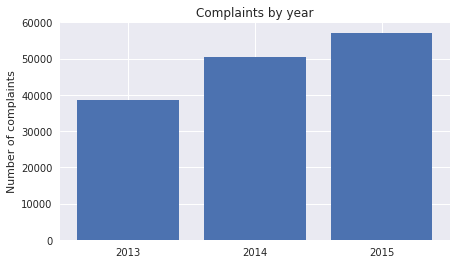

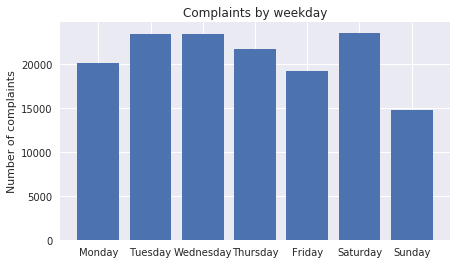

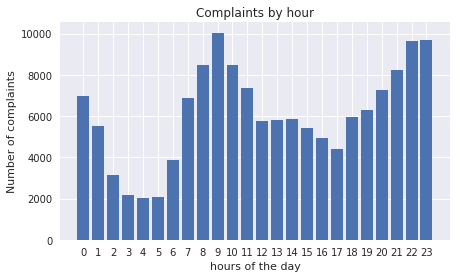

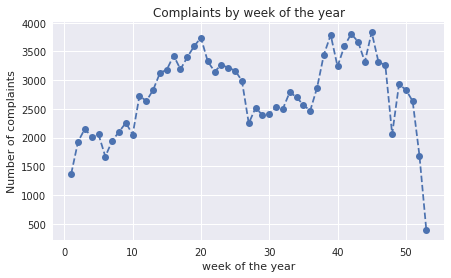

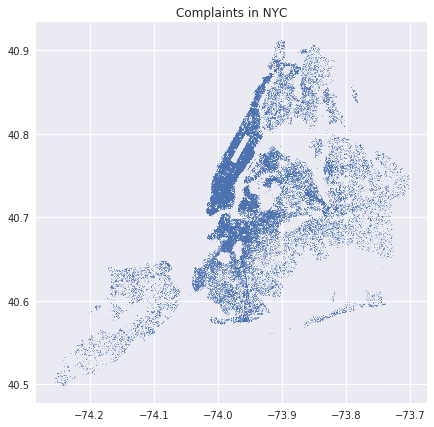

In [25]:
fig = plt.figure(figsize=(7,4))

wd = np.arange(3)
ax1 =plt.bar(wd, grpy["Unique Key"])
plt.xticks(wd, ('2013', '2014', '2015'))
pl.title("Complaints by year")
pl.ylabel("Number of complaints")

fig = plt.figure(figsize=(7,4))

wd = np.arange(7)
ax1 =plt.bar(wd, grpd["Unique Key"])
plt.xticks(wd, ('Monday', 'Tuesday', 'Wednesday', 'Thursday', "Friday", "Saturday", "Sunday"))
pl.title("Complaints by weekday")
pl.ylabel("Number of complaints")

fig = plt.figure(figsize=(7,4))

x = np.arange(24)
ax2 = plt.bar(x, grph["Unique Key"])
plt.xticks(x, ('0', '1', '2', '3', "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14",
              "15", "16", "17", "18", "19", "20", "21", "22", "23"))
pl.title("Complaints by hour")
pl.ylabel("Number of complaints")
pl.xlabel("hours of the day")

fig = plt.figure(figsize=(7,4))
ax3 = plt.figure(figsize=(7,4))
pl.plot(grpw["Unique Key"], "--o")
pl.title("Complaints by week of the year")
pl.ylabel("Number of complaints")
pl.xlabel("week of the year")

pl.figure(figsize=(7,7))
ax4 = pl.scatter(noise.Longitude, noise.Latitude, s = 0.1)
pl.title("Complaints in NYC")

In [26]:
# We drop Saturdays and Sundays because kids do not go to school those days
noise =  noise[noise["Created Date"].dt.weekday!=6]
noise =  noise[noise["Created Date"].dt.weekday!=7]

In [27]:
print ("This is our final 311 database complaint database shape:", noise.shape)

This is our final 311 database complaint database shape: (131532, 12)


In [28]:
# Because our school results are by year then we also want our noise complaints by year
noise2013 = noise[noise["Created Date"].dt.year == 2013]
noise2014 = noise[noise["Created Date"].dt.year == 2014]
noise2015 = noise[noise["Created Date"].dt.year == 2015]

In [29]:
# We create three different datasets of noise complaints (1 by year in order to groupby census tract)
noise2013.to_csv("noise2013.csv")
noise2014.to_csv("noise2014.csv")
noise2015.to_csv("noise2015.csv")

### NOTE: in order to count the number of complaints by Census Tract we used "Carto" using the analysis of counting points inside geometries. The geometries were the census tracts provided by new york city open data. It will we used in the following data processing.  

In [31]:
# We read the resulting datasets that contain the number of complaints by Census Tract
noise_13 = pd.read_csv("noisebyct2013.csv")
noise_14 = pd.read_csv("noisebyct2014.csv")
noise_15 = pd.read_csv("noisebyct2015.csv")

In [32]:
print (noise_13.shape)
print (noise_14.shape)
print (noise_15.shape)

(2028, 15)
(2054, 15)
(2070, 15)


In [33]:
# This is a way to visualize NYC that professor Federica Bianco created, it is basically a choropleth with variations.
urllib.request.urlretrieve("https://raw.githubusercontent.com/fedhere/choroplethNYC/master/choroplethNYC.py","choroplethNYC.py")
import choroplethNYC as cp

In [34]:
# Make the datasets geo data frames in order to map them
noise_13_ = gp.GeoDataFrame(noise_13)
noise_14_ = gp.GeoDataFrame(noise_14)
noise_15_ = gp.GeoDataFrame(noise_15)

In [36]:
#we unzip the census tract shapefile (it will be attached with the code in a separate file)
zip_ref = zipfile.ZipFile("2010 Census Tracts.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [98]:
# We read the file as a geodataframe
ct = gp.GeoDataFrame.from_file("geo_export_19d388ec-f34e-4b0d-b74d-a31e738347e7.shp")

In [38]:
ct.head(1)

,puma,boro_ct201,ct2010,ntaname,ntacode,boro_name,shape_leng,shape_area,cdeligibil,boro_code,ctlabel,geometry
0,3903,5000900,000900,West New Brighton-New Brighton-St. George,SI22,Staten Island,7729.016794,2.497010e+06,I,5,9,POLYGON ((-74.07920577013245 40.64343078374567...


In [39]:
noise_13_.columns

Index(['cartodb_id', 'the_geom', 'puma', 'boro_ct201', 'ct2010', 'ntaname',
       'ntacode', 'boro_name', 'shape_leng', 'shape_area', 'cdeligibil',
       'boro_code', 'ctlabel', 'count_vals', 'count_vals_density'],
      dtype='object')

In [40]:
noise_13_["boro_ct201"] = noise_13_["boro_ct201"].astype(str)
noise_14_["boro_ct201"] = noise_14_["boro_ct201"].astype(str)
noise_15_["boro_ct201"] = noise_15_["boro_ct201"].astype(str)

ct["boro_ct201"] = ct["boro_ct201"].astype(str)


In [41]:
# In order to map the number of complaints by census tract we must merge the datasets

noise_13_ = pd.merge(ct, noise_13_, on="boro_ct201")
noise_14_ = pd.merge(ct, noise_14_, on="boro_ct201")
noise_15_ = pd.merge(ct, noise_15_, on="boro_ct201")

In [42]:
noise_13_.head()

,puma_x,boro_ct201,ct2010_x,ntaname_x,ntacode_x,boro_name_x,shape_leng_x,shape_area_x,cdeligibil_x,boro_code_x,ctlabel_x,geometry,cartodb_id,the_geom,puma_y,ct2010_y,ntaname_y,ntacode_y,boro_name_y,shape_leng_y,shape_area_y,cdeligibil_y,boro_code_y,ctlabel_y,count_vals,count_vals_density
0,3903,5000900,000900,West New Brighton-New Brighton-St. George,SI22,Staten Island,7729.016794,2.497010e+06,I,5,9,POLYGON ((-74.07920577013245 40.64343078374567...,1,0106000020E6100000010000000103000000010000001C...,3903,900,West New Brighton-New Brighton-St. George,SI22,Staten Island,7729.016794,2.497010e+06,I,5,9.0,1,0.000004
1,3808,1009800,009800,Turtle Bay-East Midtown,MN19,Manhattan,5534.199811,1.906016e+06,I,1,98,POLYGON ((-73.96432543478758 40.75638153099091...,2,0106000020E61000000100000001030000000100000010...,3808,9800,Turtle Bay-East Midtown,MN19,Manhattan,5534.199811,1.906016e+06,I,1,98.0,237,0.001338
2,3808,1010000,010000,Turtle Bay-East Midtown,MN19,Manhattan,5692.168737,1.860938e+06,I,1,100,POLYGON ((-73.96802436915851 40.75957814005282...,3,0106000020E61000000100000001030000000100000016...,3808,10000,Turtle Bay-East Midtown,MN19,Manhattan,5692.168737,1.860938e+06,I,1,100.0,78,0.000451
3,3807,1010200,010200,Midtown-Midtown South,MN17,Manhattan,5687.802439,1.860993e+06,I,1,102,POLYGON ((-73.97124277307127 40.76093641847906...,4,0106000020E61000000100000001030000000100000015...,3807,10200,Midtown-Midtown South,MN17,Manhattan,5687.802439,1.860993e+06,I,1,102.0,53,0.000307
4,3807,1010400,010400,Midtown-Midtown South,MN17,Manhattan,5693.036367,1.864600e+06,I,1,104,POLYGON ((-73.97445730550224 40.76229308352487...,5,0106000020E61000000100000001030000000100000012...,3807,10400,Midtown-Midtown South,MN17,Manhattan,5693.036367,1.864600e+06,I,1,104.0,90,0.000520


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


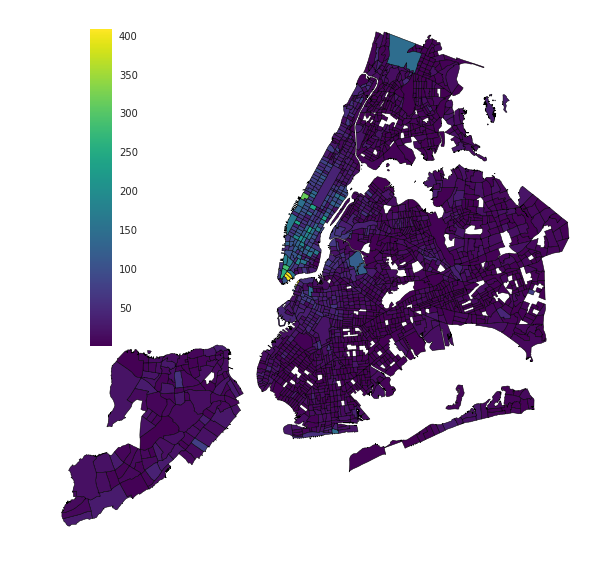

In [44]:
cp.choroplethNYC(noise_13_, column="count_vals", color="k",cmap="viridis", edgecolor="k", lw=0.5);

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


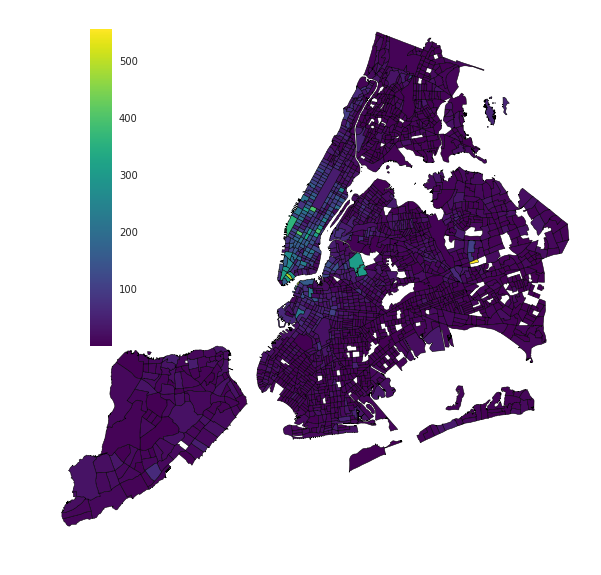

In [46]:
cp.choroplethNYC(noise_14_, column="count_vals", color="k",cmap="viridis", edgecolor="k", lw=0.5);

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


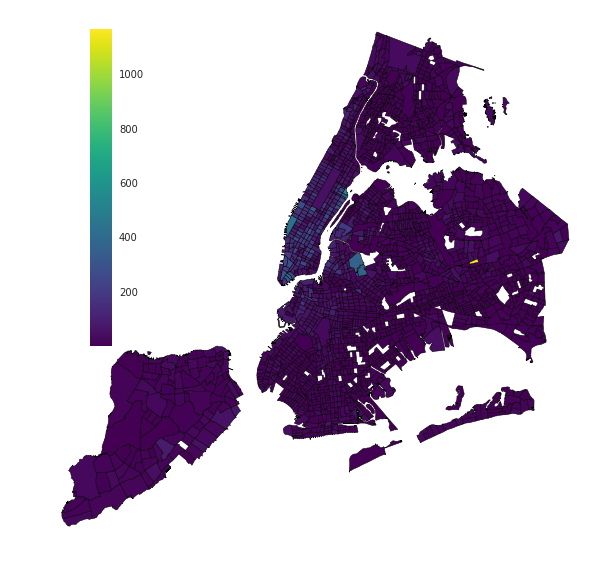

In [47]:
cp.choroplethNYC(noise_15_, column="count_vals", color="k",cmap="viridis", edgecolor="k", lw=0.5);

# SECTION 2. SCHOOL DATA MUNGING 

In [48]:
#load english and math scores and school locations from nyc open data 
math = pd.read_csv("https://data.cityofnewyork.us/api/views/gcvr-n8qw/rows.csv?accessType=DOWNLOAD")

In [49]:
english = pd.read_csv("https://data.cityofnewyork.us/api/views/jk35-yh5p/rows.csv?accessType=DOWNLOAD")


In [50]:
loc = pd.read_csv("https://data.cityofnewyork.us/api/views/ac4n-c5re/rows.csv?accessType=DOWNLOAD")

In [51]:
print(math.shape)
print(english.shape)
print(loc.shape)

(161403, 17)
(161412, 17)
(1819, 39)


In [52]:
english.columns

Index(['DBN', 'School Name', 'Grade', 'Year', 'Category', 'Number Tested',
       'Mean Scale Score', '# Level 1', '% Level 1', '# Level 2', '% Level 2',
       '# Level 3', '% Level 3', '# Level 4', '% Level 4', '# Level 3+4',
       '% Level 3+4'],
      dtype='object')

In [53]:
english.head()

,DBN,School Name,Grade,Year,Category,Number Tested,Mean Scale Score,# Level 1,% Level 1,# Level 2,% Level 2,# Level 3,% Level 3,# Level 4,% Level 4,# Level 3+4,% Level 3+4
0,01M015,P.S. 015 ROBERTO CLEMENTE,3,2013,All Students,27,289,14,51.9,11,40.7,2,7.4,0,0,2,7.4
1,01M015,P.S. 015 ROBERTO CLEMENTE,3,2014,All Students,18,285,10,55.6,8,44.4,0,0,0,0,0,0
2,01M015,P.S. 015 ROBERTO CLEMENTE,3,2015,All Students,16,282,9,56.3,5,31.3,2,12.5,0,0,2,12.5
3,01M015,P.S. 015 ROBERTO CLEMENTE,4,2013,All Students,20,278,8,40,11,55,1,5,0,0,1,5
4,01M015,P.S. 015 ROBERTO CLEMENTE,4,2014,All Students,24,284,13,54.2,10,41.7,1,4.2,0,0,1,4.2


In [54]:
loc.columns

Index(['FISCAL_YEAR', 'ATS SYSTEM CODE', 'LOCATION_CODE', 'LOCATION_NAME',
       'BEDS NUMBER', 'MANAGED_BY_NAME', 'LOCATION_TYPE_DESCRIPTION',
       'LOCATION_CATEGORY_DESCRIPTION', 'GRADES_TEXT', 'GRADES_FINAL_TEXT',
       'OPEN_DATE', 'STATUS_DESCRIPTIONS', 'PRIMARY_BUILDING_CODE',
       'PRIMARY_ADDRESS_LINE_1', 'STATE_CODE', 'X_COORDINATE', 'Y_COORDINATE',
       'COMMUNITY_DISTRICT', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BOROUGH_BLOCK_LOT', 'NTA', 'NTA_NAME', 'PRINCIPAL_NAME',
       'PRINCIPAL_TITLE', 'PRINCIPAL_PHONE_NUMBER', 'FAX_NUMBER',
       'GEOGRAPHICAL_DISTRICT_CODE', 'ADMIN_DISTRICT_LOCATION_CODE',
       'ADMINISTRATIVE_DISTRICT_NAME', 'COMMUNITY_SCHOOL_SUP_NAME',
       'FIELD_SUPPORT_CENTER_NAME', 'FIELD_SUPPORT_CENTER_LEADER_NAME',
       'SCHOOL_SUPPORT_TEAM_NAME', 'SCHOOL_SUPPORT_TEAM_LEADER_NAME',
       'HIGHSCHOOL_NETWORK_LOCATION_CODE', 'HIGHSCHOOL_NETWORK_NAME',
       'HIGHSCHOOL_NETWORK_SUPERINTENDENT', 'Location 1'],
      dtype='object')

In [55]:
print(len(math.DBN.unique()))
print(len(english.DBN.unique()))

1133
1132


In [56]:
#shorten english and math dataframes to only include average scores from all grades
english = english[english["Grade"] == "All Grades"]
math = math[math["Grade"] == "All Grades"]

In [57]:
print(english.shape)
print(math.shape)

(38930, 17)
(38978, 17)


In [58]:
#create dataframes for each year of test scores
english2013 = english[english["Year"] == 2013]
english2014 = english[english["Year"] == 2014]
english2015 = english[english["Year"] == 2015]

math2013 = math[math["Year"] == 2013]
math2014 = math[math["Year"] == 2014]
math2015 = math[math["Year"] == 2015]

In [59]:
print("math 2013",math2013.shape)
print("math 2014",math2014.shape)
print("math 2015",math2015.shape)

print("english 2013",english2013.shape)
print("english 2014",english2014.shape)
print("english 2015",english2015.shape)

math 2013 (12730, 17)
math 2014 (13026, 17)
math 2015 (13222, 17)
english 2013 (12715, 17)
english 2014 (13012, 17)
english 2015 (13203, 17)


In [60]:
#create BDN column in location data
loc["DBN"] = loc["ATS SYSTEM CODE"].str[:6]

In [61]:
loc.columns

Index(['FISCAL_YEAR', 'ATS SYSTEM CODE', 'LOCATION_CODE', 'LOCATION_NAME',
       'BEDS NUMBER', 'MANAGED_BY_NAME', 'LOCATION_TYPE_DESCRIPTION',
       'LOCATION_CATEGORY_DESCRIPTION', 'GRADES_TEXT', 'GRADES_FINAL_TEXT',
       'OPEN_DATE', 'STATUS_DESCRIPTIONS', 'PRIMARY_BUILDING_CODE',
       'PRIMARY_ADDRESS_LINE_1', 'STATE_CODE', 'X_COORDINATE', 'Y_COORDINATE',
       'COMMUNITY_DISTRICT', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BOROUGH_BLOCK_LOT', 'NTA', 'NTA_NAME', 'PRINCIPAL_NAME',
       'PRINCIPAL_TITLE', 'PRINCIPAL_PHONE_NUMBER', 'FAX_NUMBER',
       'GEOGRAPHICAL_DISTRICT_CODE', 'ADMIN_DISTRICT_LOCATION_CODE',
       'ADMINISTRATIVE_DISTRICT_NAME', 'COMMUNITY_SCHOOL_SUP_NAME',
       'FIELD_SUPPORT_CENTER_NAME', 'FIELD_SUPPORT_CENTER_LEADER_NAME',
       'SCHOOL_SUPPORT_TEAM_NAME', 'SCHOOL_SUPPORT_TEAM_LEADER_NAME',
       'HIGHSCHOOL_NETWORK_LOCATION_CODE', 'HIGHSCHOOL_NETWORK_NAME',
       'HIGHSCHOOL_NETWORK_SUPERINTENDENT', 'Location 1', 'DBN'],
      dtype='object')

In [62]:
#merge school locations and test scores based on DBN
eng2013 = pd.merge(loc, english2013, right_on="DBN", left_on="DBN", how = "inner")
eng2014 = pd.merge(loc, english2014, right_on="DBN", left_on="DBN", how = "inner")
eng2015 = pd.merge(loc, english2015, right_on="DBN", left_on="DBN", how = "inner")

math2013 = pd.merge(loc, math2013, right_on="DBN", left_on="DBN", how = "inner")
math2014 = pd.merge(loc, math2014, right_on="DBN", left_on="DBN", how = "inner")
math2015 = pd.merge(loc, math2015, right_on="DBN", left_on="DBN", how = "inner")

In [63]:
print("math 2013",math2013.shape)
print("math 2014",math2014.shape)
print("math 2015",math2015.shape)

print("english 2013",english2013.shape)
print("english 2014",english2014.shape)
print("english 2015",english2015.shape)

math 2013 (12730, 56)
math 2014 (13026, 56)
math 2015 (13139, 56)
english 2013 (12715, 17)
english 2014 (13012, 17)
english 2015 (13203, 17)


In [64]:
eng2013 = eng2013[eng2013["Mean Scale Score"].str.contains("s") == False]
eng2014 = eng2014[eng2014["Mean Scale Score"].str.contains("s") == False]
eng2015 = eng2015[eng2015["Mean Scale Score"].str.contains("s") == False]

math2013 = math2013[math2013["Mean Scale Score"].str.contains("s") == False]
math2014 = math2014[math2014["Mean Scale Score"].str.contains("s") == False]
math2015 = math2015[math2015["Mean Scale Score"].str.contains("s") == False]

In [65]:
#convert mean scale score to integer
eng2013["mean"] = eng2013["Mean Scale Score"].astype(int)
eng2014["mean"] = eng2014["Mean Scale Score"].astype(int)
eng2015["mean"] = eng2015["Mean Scale Score"].astype(int)

math2013["mean"] = math2013["Mean Scale Score"].astype(int)
math2014["mean"] = math2014["Mean Scale Score"].astype(int)
math2015["mean"] = math2015["Mean Scale Score"].astype(int)

In [66]:
engall2013 = eng2013[eng2013["Category"] == "All Students"]
engall2014 = eng2014[eng2014["Category"] == "All Students"]
engall2015 = eng2015[eng2015["Category"] == "All Students"]

mathall2013 = math2013[math2013["Category"] == "All Students"]
mathall2014 = math2014[math2014["Category"] == "All Students"]
mathall2015 = math2015[math2015["Category"] == "All Students"]

In [67]:
print(engall2013.shape)
print(engall2014.shape)
print(engall2015.shape)

print(mathall2013.shape)
print(mathall2014.shape)
print(mathall2015.shape)

(1086, 57)
(1115, 57)
(1124, 57)
(1086, 57)
(1115, 57)
(1125, 57)


In [68]:
engall2013["English Mean Score"] = engall2015["mean"]
engall2014["English Mean Score"] = engall2015["mean"]
engall2015["English Mean Score"] = engall2015["mean"]

mathall2013["Math Mean Score"] = mathall2015["mean"]
mathall2014["Math Mean Score"] = mathall2015["mean"]
mathall2015["Math Mean Score"] = mathall2015["mean"]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to 

In [69]:
#examine mean test scores in each year

Text(0.5,0,'English scores')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


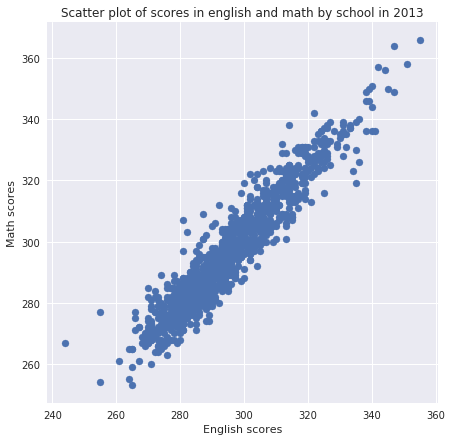

In [70]:
#2013
pl.figure(figsize=(7,7))
pl.scatter(engall2013["mean"], mathall2013["mean"])
pl.title("Scatter plot of scores in english and math by school in 2013")
pl.ylabel("Math scores")
pl.xlabel("English scores")

Text(0.5,0,'English scores')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


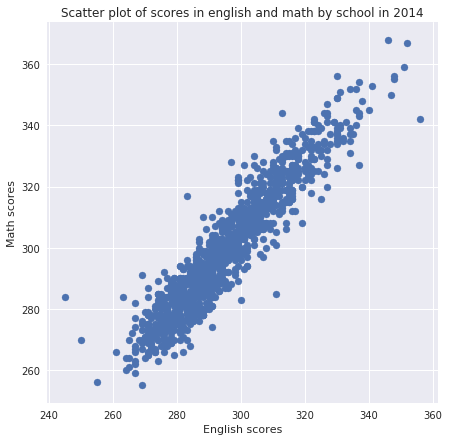

In [71]:
#2014
pl.figure(figsize=(7,7))
pl.scatter(engall2014["mean"], mathall2014["mean"])
pl.title("Scatter plot of scores in english and math by school in 2014")
pl.ylabel("Math scores")
pl.xlabel("English scores")

Text(0.5,0,'English scores')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


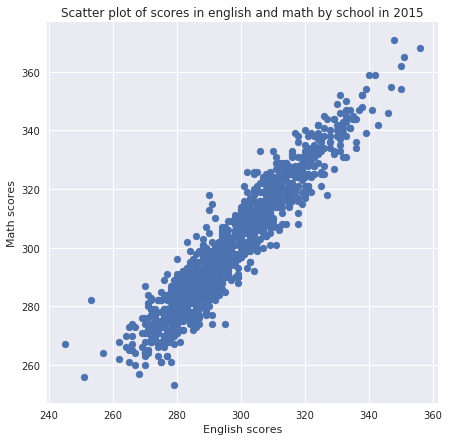

In [72]:
#for 2015 we must first merge english and math scores to drop additional school in math data
a = pd.merge(engall2015, mathall2015, on = "DBN")

pl.figure(figsize=(7,7))
pl.scatter(a["English Mean Score"], a["Math Mean Score"])
pl.title("Scatter plot of scores in english and math by school in 2015")
pl.ylabel("Math scores")
pl.xlabel("English scores")

In [73]:
#now we merge the test score data with the census tracts

In [77]:
engall2013.columns

Index(['FISCAL_YEAR', 'ATS SYSTEM CODE', 'LOCATION_CODE', 'LOCATION_NAME',
       'BEDS NUMBER', 'MANAGED_BY_NAME', 'LOCATION_TYPE_DESCRIPTION',
       'LOCATION_CATEGORY_DESCRIPTION', 'GRADES_TEXT', 'GRADES_FINAL_TEXT',
       'OPEN_DATE', 'STATUS_DESCRIPTIONS', 'PRIMARY_BUILDING_CODE',
       'PRIMARY_ADDRESS_LINE_1', 'STATE_CODE', 'X_COORDINATE', 'Y_COORDINATE',
       'COMMUNITY_DISTRICT', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BOROUGH_BLOCK_LOT', 'NTA', 'NTA_NAME', 'PRINCIPAL_NAME',
       'PRINCIPAL_TITLE', 'PRINCIPAL_PHONE_NUMBER', 'FAX_NUMBER',
       'GEOGRAPHICAL_DISTRICT_CODE', 'ADMIN_DISTRICT_LOCATION_CODE',
       'ADMINISTRATIVE_DISTRICT_NAME', 'COMMUNITY_SCHOOL_SUP_NAME',
       'FIELD_SUPPORT_CENTER_NAME', 'FIELD_SUPPORT_CENTER_LEADER_NAME',
       'SCHOOL_SUPPORT_TEAM_NAME', 'SCHOOL_SUPPORT_TEAM_LEADER_NAME',
       'HIGHSCHOOL_NETWORK_LOCATION_CODE', 'HIGHSCHOOL_NETWORK_NAME',
       'HIGHSCHOOL_NETWORK_SUPERINTENDENT', 'Location 1', 'DBN', 'School Name',
       

In [78]:
#we must create BoroCT2010 in the test score data in order to merge

In [79]:
engall2013["Borough_Code"] = engall2013["LOCATION_CODE"].str[0]
engall2014["Borough_Code"] = engall2014["LOCATION_CODE"].str[0]
engall2015["Borough_Code"] = engall2015["LOCATION_CODE"].str[0]

mathall2013["Borough_Code"] = mathall2013["LOCATION_CODE"].str[0]
mathall2014["Borough_Code"] = mathall2014["LOCATION_CODE"].str[0]
mathall2015["Borough_Code"] = mathall2015["LOCATION_CODE"].str[0]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to 

In [80]:
def b_num(letter): 
    if letter == "K":
        return "3"
    elif letter == "X":
        return "2"
    elif letter == "Q":
        return "4"
    elif letter == "M":
        return "1"
    elif letter == "R":
        return "5"
engall2013["Borough_Code"].apply(b_num)
engall2014["Borough_Code"].apply(b_num)
engall2015["Borough_Code"].apply(b_num)

mathall2013["Borough_Code"].apply(b_num)
mathall2014["Borough_Code"].apply(b_num)
mathall2015["Borough_Code"].apply(b_num)

0        1
11       1
23       1
35       1
47       1
59       1
71       1
83       1
95       1
107      1
119      1
131      1
143      1
155      1
167      1
179      1
189      1
201      1
213      1
225      1
236      1
248      1
260      1
272      1
283      1
295      1
306      1
318      1
330      1
342      1
        ..
12785    5
12797    5
12809    5
12821    5
12833    5
12845    5
12857    5
12869    5
12881    5
12893    5
12905    3
12917    3
12929    3
12941    3
12953    3
12964    3
12976    3
12988    3
12999    3
13011    3
13023    3
13035    3
13046    3
13058    3
13069    3
13080    3
13092    3
13104    3
13116    3
13127    3
Name: Borough_Code, dtype: object

In [81]:
#convert borough codes to borough numbers
engall2013["Borough_Num"] = engall2013["Borough_Code"].apply(b_num)
engall2014["Borough_Num"] = engall2014["Borough_Code"].apply(b_num)
engall2015["Borough_Num"] = engall2015["Borough_Code"].apply(b_num)

mathall2013["Borough_Num"] = mathall2013["Borough_Code"].apply(b_num)
mathall2014["Borough_Num"] = mathall2014["Borough_Code"].apply(b_num)
mathall2015["Borough_Num"] = mathall2015["Borough_Code"].apply(b_num)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to b

In [82]:
engall2013["CENSUS_TRACT"] = engall2013['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
engall2014["CENSUS_TRACT"] = engall2014['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
engall2015["CENSUS_TRACT"] = engall2015['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)

mathall2013["CENSUS_TRACT"] = mathall2013['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
mathall2014["CENSUS_TRACT"] = mathall2014['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
mathall2015["CENSUS_TRACT"] = mathall2015['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to 

In [83]:
#create BoroCT2010
engall2013["BoroCT2010"] = engall2013["Borough_Num"] + engall2013["CENSUS_TRACT"]
engall2014["BoroCT2010"] = engall2014["Borough_Num"] + engall2014["CENSUS_TRACT"]
engall2015["BoroCT2010"] = engall2015["Borough_Num"] + engall2015["CENSUS_TRACT"]

mathall2013["BoroCT2010"] = mathall2013["Borough_Num"] + mathall2013["CENSUS_TRACT"]
mathall2014["BoroCT2010"] = mathall2014["Borough_Num"] + mathall2014["CENSUS_TRACT"]
mathall2015["BoroCT2010"] = mathall2015["Borough_Num"] + mathall2015["CENSUS_TRACT"]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to b

In [84]:
#convert to int
engall2013["BoroCT2010"] = engall2013["BoroCT2010"].astype(int)
engall2014["BoroCT2010"] = engall2014["BoroCT2010"].astype(int)
engall2015["BoroCT2010"] = engall2015["BoroCT2010"].astype(int)

mathall2013["BoroCT2010"] = mathall2013["BoroCT2010"].astype(int)
mathall2014["BoroCT2010"] = mathall2014["BoroCT2010"].astype(int)
mathall2015["BoroCT2010"] = mathall2015["BoroCT2010"].astype(int)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to b

In [85]:
#now merge with census tract data
engall2013 = pd.merge(ct, engall2013, on="BoroCT2010", how = "inner")
engall2014 = pd.merge(ct, engall2014, on="BoroCT2010", how = "inner")
engall2015 = pd.merge(ct, engall2015, on="BoroCT2010", how = "inner")

mathall2013 = pd.merge(ct, mathall2013, on="BoroCT2010", how = "inner")
mathall2014 = pd.merge(ct, mathall2014, on="BoroCT2010", how = "inner")
mathall2015 = pd.merge(ct, mathall2015, on="BoroCT2010", how = "inner")

In [86]:
print(engall2013.shape)
print(engall2014.shape)
print(engall2015.shape)

print(mathall2013.shape)
print(mathall2014.shape)
print(mathall2015.shape)

(1086, 72)
(1115, 72)
(1124, 72)
(1086, 72)
(1115, 72)
(1125, 72)


In [87]:
#rename mean score column in each df
engall2013.rename(columns={"Mean Scale Score":"Eng2013_Mean"}, inplace=True)
engall2014.rename(columns={"Mean Scale Score":"Eng2014_Mean"}, inplace=True)
engall2015.rename(columns={"Mean Scale Score":"Eng2015_Mean"}, inplace=True)

mathall2013.rename(columns={"Mean Scale Score":"Math2013_Mean"}, inplace=True)
mathall2014.rename(columns={"Mean Scale Score":"Math2014_Mean"}, inplace=True)
mathall2015.rename(columns={"Mean Scale Score":"Math2015_Mean"}, inplace=True)

In [88]:
#now combine enligsh and math scores in each year
scores2013 = pd.merge(engall2013,mathall2013[['ATS SYSTEM CODE','Math2013_Mean']],on='ATS SYSTEM CODE', how='left')
scores2014 = pd.merge(engall2014,mathall2014[['ATS SYSTEM CODE','Math2014_Mean']],on='ATS SYSTEM CODE', how='left')
scores2015 = pd.merge(engall2015,mathall2015[['ATS SYSTEM CODE','Math2015_Mean']],on='ATS SYSTEM CODE', how='left')

In [89]:
scores2013.head()

,CTLabel,the_geom,BoroName,BoroCode,CT2010,BoroCT2010,CDEligibil,NTACode,NTAName,PUMA,Shape_Leng,Shape_Area,FISCAL_YEAR,ATS SYSTEM CODE,LOCATION_CODE,LOCATION_NAME,BEDS NUMBER,MANAGED_BY_NAME,LOCATION_TYPE_DESCRIPTION,LOCATION_CATEGORY_DESCRIPTION,GRADES_TEXT,GRADES_FINAL_TEXT,OPEN_DATE,STATUS_DESCRIPTIONS,PRIMARY_BUILDING_CODE,PRIMARY_ADDRESS_LINE_1,STATE_CODE,X_COORDINATE,Y_COORDINATE,COMMUNITY_DISTRICT,COUNCIL_DISTRICT,CENSUS_TRACT,BOROUGH_BLOCK_LOT,NTA,NTA_NAME,PRINCIPAL_NAME,PRINCIPAL_TITLE,PRINCIPAL_PHONE_NUMBER,FAX_NUMBER,GEOGRAPHICAL_DISTRICT_CODE,ADMIN_DISTRICT_LOCATION_CODE,ADMINISTRATIVE_DISTRICT_NAME,COMMUNITY_SCHOOL_SUP_NAME,FIELD_SUPPORT_CENTER_NAME,FIELD_SUPPORT_CENTER_LEADER_NAME,SCHOOL_SUPPORT_TEAM_NAME,SCHOOL_SUPPORT_TEAM_LEADER_NAME,HIGHSCHOOL_NETWORK_LOCATION_CODE,HIGHSCHOOL_NETWORK_NAME,HIGHSCHOOL_NETWORK_SUPERINTENDENT,Location 1,DBN,School Name,Grade,Year,Category,Number Tested,Eng2013_Mean,# Level 1,% Level 1,# Level 2,% Level 2,# Level 3,% Level 3,# Level 4,% Level 4,# Level 3+4,% Level 3+4,mean,English Mean Score,Borough_Code,Borough_Num,Math2013_Mean
0,9.0,MULTIPOLYGON (((-74.07920577013245 40.64343078...,Staten Island,5,900,5000900,I,SI22,West New Brighton-New Brighton-St. George,3903,7729.016794,2.497010e+06,2014,31R031,R031,P.S. 031 William T. Davis,353100010031,DOE,General Academic,Elementary,"PK,0K,01,02,03,04,05,SE","PK,0K,01,02,03,04,05",07/01/1965 12:00:00 AM,Open,R031,55 LAYTON AVENUE,NY,960544.0,173219.0,501,49,000900,5000490182,SI22,West New Brighton-New Brighton-St. George ...,PATRICIA COVINGTON,PRINCIPAL,718-273-3500,718-815-4826,31,NaN,COMMUNITY SCHOOL DISTRICT 31,"JENKINS, JESSICA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"55 LAYTON AVENUE\nSTATEN ISLAND, NY 10301\n(40...",31R031,P.S. 031 WILLIAM T. DAVIS,All Grades,2013,All Students,230,279,135,58.7,71,30.9,20,8.7,4,1.7,24,10.4,279,281.0,R,5,281
1,190.0,MULTIPOLYGON (((-73.94505127984516 40.80259859...,Manhattan,1,19000,1019000,I,MN11,Central Harlem South,3803,4231.826839,1.117372e+06,2014,03M149,M149,P.S. 149 Sojourner Truth,310300010149,DOE,General Academic,K-8,"PK,0K,01,02,03,04,05,06,07,08,SE","PK,0K,01,02,03,04,05,06,07,08",12/04/1990 12:00:00 AM,Open,M207,41 WEST 117 STREET,NY,998622.0,231708.0,110,9,019000,1016010001,MN11,Central Harlem South ...,Barbara Darrigo,PRINCIPAL,646-672-9020,646-672-9302,3,NaN,COMMUNITY SCHOOL DISTRICT 03,"ALTSCHUL, ILENE",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"41 WEST 117 STREET\nMANHATTAN, NY 10026\n(40.8...",03M149,P.S. 149 SOJOURNER TRUTH,All Grades,2013,All Students,185,276,110,59.5,62,33.5,12,6.5,1,0.5,13,7,276,NaN,M,1,272
2,206.0,MULTIPOLYGON (((-73.93580780201182 40.80949763...,Manhattan,1,20600,1020600,E,MN03,Central Harlem North-Polo Grounds,3803,5176.873150,1.602694e+06,2014,05M133,M133,P.S. 133 Fred R Moore,310500010133,DOE,General Academic,Elementary,"PK,0K,01,02,03,04,05,SE","PK,0K,01,02,03,04,05",07/01/1949 12:00:00 AM,Open,M133,2121 5 AVENUE,NY,1001087.0,234266.0,111,9,020600,1017550001,MN03,Central Harlem North-Polo Grounds ...,Patricia Balbuena,I.A. PRINCIPAL,212-690-5936,212-690-5939,5,NaN,COMMUNITY SCHOOL DISTRICT 05,"REEVES, GALE",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2121 5 AVENUE\nMANHATTAN, NY 10037\n(40.809665...",05M133,P.S. 133 FRED R MOORE,All Grades,2013,All Students,120,279,65,54.2,44,36.7,8,6.7,3,2.5,11,9.2,279,NaN,M,1,275
3,206.0,MULTIPOLYGON (((-73.93580780201182 40.80949763...,Manhattan,1,20600,1020600,E,MN03,Central Harlem North-Polo Grounds,3803,5176.873150,1.602694e+06,2014,05M469,M469,Choir Academy of Harlem,310500011469,DOE,General Academic,Secondary School,"07,08,10,11,12,SE","06,07,08,09,10,11,12",06/05/1996 12:00:00 AM,Open,M501,2005 MADISON AVENUE,NY,1001216.0,233302.0,111,9,020600,1017520022,MN03,Central Harlem North-Polo Grounds ...,Dr. Melissa Vaughan,PRINCIPAL,212-289-6227,212-289-4195,5,NaN,COMMUNITY SCHOOL DISTRICT 05,NaN,NaN,NaN,NaN,NaN,HS09,HS Network 09,"HALLETT, DENISE","2005 MADISON AVENUE\nMANHATTAN, NY 10035\n(40....",05M469,CHOIR ACADEMY OF HARLEM,All Grades,2013,All Students,

In [90]:
#shorten dataframes to include only columns we need
scores2013_short = scores2013[["the_geom", "BoroCode", "BoroCT2010", "LOCATION_NAME", "LOCATION_TYPE_DESCRIPTION",
                              "LOCATION_CATEGORY_DESCRIPTION", "X_COORDINATE", "Y_COORDINATE", "BOROUGH_BLOCK_LOT",
                              "DBN", "Number Tested", "Eng2013_Mean", "Math2013_Mean"]]

scores2014_short = scores2014[["the_geom", "BoroCode", "BoroCT2010", "LOCATION_NAME", "LOCATION_TYPE_DESCRIPTION",
                              "LOCATION_CATEGORY_DESCRIPTION", "X_COORDINATE", "Y_COORDINATE", "BOROUGH_BLOCK_LOT",
                              "DBN", "Number Tested", "Eng2014_Mean", "Math2014_Mean"]]

scores2015_short = scores2015[["the_geom", "BoroCode", "BoroCT2010", "LOCATION_NAME", "LOCATION_TYPE_DESCRIPTION",
                              "LOCATION_CATEGORY_DESCRIPTION", "X_COORDINATE", "Y_COORDINATE", "BOROUGH_BLOCK_LOT",
                              "DBN", "Number Tested", "Eng2015_Mean", "Math2015_Mean"]]

In [91]:
print('the size of the 2013 tests data is', scores2013_short.shape)
print('the size of the 2014 tests data is', scores2014_short.shape)
print('the size of the 2015 tests data is', scores2015_short.shape)

the size of the 2013 tests data is (1086, 13)
the size of the 2014 tests data is (1115, 13)
the size of the 2015 tests data is (1124, 13)


In [99]:
ct.columns

Index(['puma', 'boro_ct201', 'ct2010', 'ntaname', 'ntacode', 'boro_name',
       'shape_leng', 'shape_area', 'cdeligibil', 'boro_code', 'ctlabel',
       'geometry'],
      dtype='object')

In [100]:
ct["boro_ct201"] = ct["boro_ct201"].astype(str)
scores2015_short["BoroCT2010"] = scores2015_short["BoroCT2010"].astype(str)
scores2013_short["BoroCT2010"] = scores2015_short["BoroCT2010"].astype(str)
scores2014_short["BoroCT2010"] = scores2015_short["BoroCT2010"].astype(str)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to b

In [101]:
graphs2013 = pd.merge(scores2013_short, ct, left_on="BoroCT2010", right_on="boro_ct201")
graphs2014 = pd.merge(scores2014_short, ct, left_on="BoroCT2010", right_on="boro_ct201")
graphs2015 = pd.merge(scores2015_short, ct, left_on="BoroCT2010", right_on="boro_ct201")

In [102]:
print(graphs2013.shape)
print(graphs2014.shape)
print(graphs2015.shape)

(1086, 25)
(1115, 25)
(1124, 25)


In [103]:
graphs2013.head()

,the_geom,BoroCode,BoroCT2010,LOCATION_NAME,LOCATION_TYPE_DESCRIPTION,LOCATION_CATEGORY_DESCRIPTION,X_COORDINATE,Y_COORDINATE,BOROUGH_BLOCK_LOT,DBN,Number Tested,Eng2013_Mean,Math2013_Mean,puma,boro_ct201,ct2010,ntaname,ntacode,boro_name,shape_leng,shape_area,cdeligibil,boro_code,ctlabel,geometry
0,MULTIPOLYGON (((-74.07920577013245 40.64343078...,5,5000900,P.S. 031 William T. Davis,General Academic,Elementary,960544.0,173219.0,5000490182,31R031,230,279,281,3903,5000900,000900,West New Brighton-New Brighton-St. George,SI22,Staten Island,7729.016794,2.497010e+06,I,5,9,POLYGON ((-74.07920577013245 40.64343078374567...
1,MULTIPOLYGON (((-73.94505127984516 40.80259859...,1,1019000,P.S. 149 Sojourner Truth,General Academic,K-8,998622.0,231708.0,1016010001,03M149,185,276,272,3803,1019000,019000,Central Harlem South,MN11,Manhattan,4231.826839,1.117372e+06,I,1,190,POLYGON ((-73.94505127984516 40.80259859871748...
2,MULTIPOLYGON (((-73.93580780201182 40.80949763...,1,1020600,P.S. 133 Fred R Moore,General Academic,Elementary,1001087.0,234266.0,1017550001,05M133,120,279,275,3803,1020600,020600,Central Harlem North-Polo Grounds,MN03,Manhattan,5176.873150,1.602694e+06,E,1,206,POLYGON ((-73.93580780201182 40.80949763825763...
3,MULTIPOLYGON (((-73.93580780201182 40.80949763...,1,1020600,Choir Academy of Harlem,General Academic,Secondary School,1001216.0,233302.0,1017520022,05M469,140,265,265,3803,1020600,020600,Central Harlem North-Polo Grounds,MN03,Manhattan,5176.873150,1.602694e+06,E,1,206,POLYGON ((-73.93580780201182 40.80949763825763...
4,MULTIPOLYGON (((-73.93669078722112 40.83719324...,1,1024900,P.S. 008 Luis Belliard,General Academic,Elementary,1001789.0,245040.0,1021120001,06M008,272,284,287,3801,1024900,024900,Washington Heights South,MN36,Manhattan,3927.821449,6.528564e+05,E,1,249,POLYGON ((-73.93669078722112 40.83719324953258...


In [104]:
geoscores2013_short = gp.GeoDataFrame(graphs2013)
geoscores2014_short = gp.GeoDataFrame(graphs2014)
geoscores2015_short = gp.GeoDataFrame(graphs2015)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


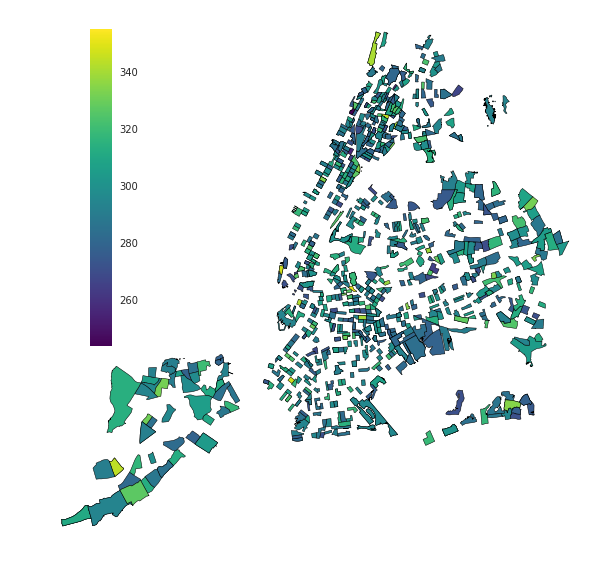

In [105]:
#graphing 2013 mean English scores by census tract
cp.choroplethNYC(geoscores2013_short, column="Eng2013_Mean", color="k",cmap="viridis", edgecolor="k", lw=0.5);

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


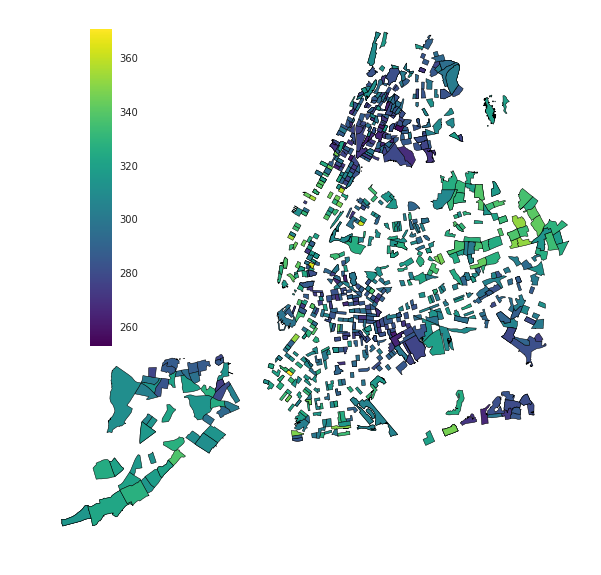

In [106]:
#graphing 2013 mean math scores by census tract
cp.choroplethNYC(geoscores2015_short, column="Math2015_Mean", color="k",cmap="viridis", edgecolor="k", lw=0.5);

In [107]:
#now we can merge test scores by census tract with noise complaints by census tract
#load in noise complaint data
noise13 = pd.read_csv("noisebyct2013.csv")
noise14 = pd.read_csv("noisebyct2014.csv")
noise15 = pd.read_csv("noisebyct2015.csv")

In [108]:
print(noise13.shape)
print(noise14.shape)
print(noise15.shape)

(2028, 15)
(2054, 15)
(2070, 15)


In [109]:
#shorten noise complaints data to only contain census tract, number of complaints, and complaint density
noise13 = noise13[["boro_ct201", "count_vals", "count_vals_density"]]
noise14 = noise14[["boro_ct201", "count_vals", "count_vals_density"]]
noise15 = noise15[["boro_ct201", "count_vals", "count_vals_density"]]

In [110]:
print(noise13.shape)
print(noise14.shape)
print(noise15.shape)

(2028, 3)
(2054, 3)
(2070, 3)


In [111]:
#convert census tracts to string
noise13["boro_ct201"] = noise13["boro_ct201"].astype(str)
noise14["boro_ct201"] = noise14["boro_ct201"].astype(str)
noise15["boro_ct201"] = noise15["boro_ct201"].astype(str)

In [112]:
scores2013_final = pd.merge(noise13, geoscores2013_short, left_on="boro_ct201", right_on="BoroCT2010")
scores2014_final = pd.merge(noise14, geoscores2014_short, left_on="boro_ct201", right_on="BoroCT2010")
scores2015_final = pd.merge(noise15, geoscores2015_short, left_on="boro_ct201", right_on="BoroCT2010")

In [113]:
scores2013_final.head()

,boro_ct201_x,count_vals,count_vals_density,the_geom,BoroCode,BoroCT2010,LOCATION_NAME,LOCATION_TYPE_DESCRIPTION,LOCATION_CATEGORY_DESCRIPTION,X_COORDINATE,Y_COORDINATE,BOROUGH_BLOCK_LOT,DBN,Number Tested,Eng2013_Mean,Math2013_Mean,puma,boro_ct201_y,ct2010,ntaname,ntacode,boro_name,shape_leng,shape_area,cdeligibil,boro_code,ctlabel,geometry
0,2023301,8,0.000068,MULTIPOLYGON (((-73.8879964361467 40.816663385...,2,2023301,P.S. 048 Joseph R. Drake,General Academic,Elementary,1015575.0,235872.0,2027660001,08X048,327,283.0,285,3707,2023301,023301,Mount Hope,BX41,Bronx,4498.012387,1.272774e+06,E,2,233.01,POLYGON ((-73.90698472353698 40.85038248671983...
1,2023301,8,0.000068,MULTIPOLYGON (((-73.87663459963709 40.81571150...,2,2023301,The Hunts Point School,General Academic,Junior High-Intermediate-Middle,1016003.0,236526.0,2027630279,08X424,375,270.0,269,3707,2023301,023301,Mount Hope,BX41,Bronx,4498.012387,1.272774e+06,E,2,233.01,POLYGON ((-73.90698472353698 40.85038248671983...
2,2023301,8,0.000068,MULTIPOLYGON (((-73.7576312961815 40.666451156...,4,2023301,P.S. 052 Queens,General Academic,Elementary,1048849.0,180338.0,4133530020,29Q052,237,294.0,285,3707,2023301,023301,Mount Hope,BX41,Bronx,4498.012387,1.272774e+06,E,2,233.01,POLYGON ((-73.90698472353698 40.85038248671983...
3,1007100,105,0.000636,MULTIPOLYGON (((-73.83737956188475 40.89392474...,2,1007100,P.S. 068 Bronx,General Academic,Elementary,1028797.0,264154.0,2049860081,11X068,370,288.0,292,3810,1007100,007100,West Village,MN23,Manhattan,6601.034466,1.775751e+06,I,1,71,"POLYGON ((-73.9968399392649 40.7373608893982, ..."
4,3064600,6,0.000036,MULTIPOLYGON (((-73.92842985426594 40.61497277...,3,3064600,P.S. 207 Elizabeth G. Leary,General Academic,K-8,1003550.0,162974.0,3084840001,22K207,777,316.0,315,4009,3064600,064600,Georgetown-Marine Park-Bergen Beach-Mill Basin,BK45,Brooklyn,5619.588955,1.782721e+06,I,3,646,POLYGON ((-73.93605774303619 40.61512319639314...


In [114]:
#convert to geo dataframe for mapping 
geoscores2015_final = gp.GeoDataFrame(scores2015_final)
geoscores2013_final = gp.GeoDataFrame(scores2013_final)
geoscores2014_final = gp.GeoDataFrame(scores2014_final)

In [115]:
#convert all test scores to int
geoscores2013_final["Eng2013_Mean"] = geoscores2013_final["Eng2013_Mean"].astype(int)
geoscores2014_final["Eng2014_Mean"] = geoscores2014_final["Eng2014_Mean"].astype(int)
geoscores2015_final["Eng2015_Mean"] = geoscores2015_final["Eng2015_Mean"].astype(int)

geoscores2013_final["Math2013_Mean"] = geoscores2013_final["Math2013_Mean"].astype(int)
geoscores2014_final["Math2014_Mean"] = geoscores2014_final["Math2014_Mean"].astype(int)
geoscores2015_final["Math2015_Mean"] = geoscores2015_final["Math2015_Mean"].astype(int)

In [116]:
#now create graphs to examine the effect noise complaints on test scores
import matplotlib.pyplot as plt

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,0.98,'Effect of Noise Complaints of 2013 Math Scores')

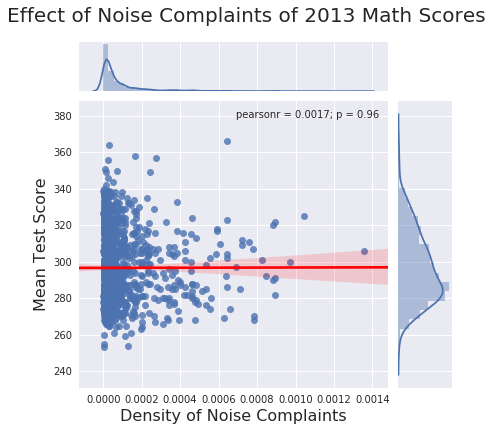

In [117]:
math2013_trend = sn.jointplot("count_vals_density", "Math2013_Mean", data =geoscores2013_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
math2013_trend.fig.suptitle('Effect of Noise Complaints of 2013 Math Scores', fontsize=20)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,0.98,'Effect of Noise Complaints of 2013 English Scores')

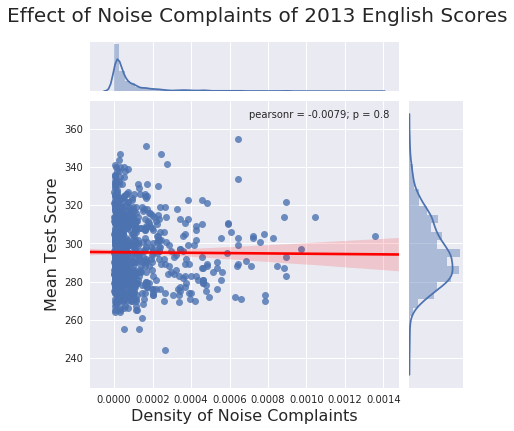

In [118]:
eng2013_trend = sn.jointplot("count_vals_density", "Eng2013_Mean", data =geoscores2013_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
eng2013_trend.fig.suptitle('Effect of Noise Complaints of 2013 English Scores', fontsize=20)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,0.98,'Effect of Noise Complaints of 2014 Math Scores')

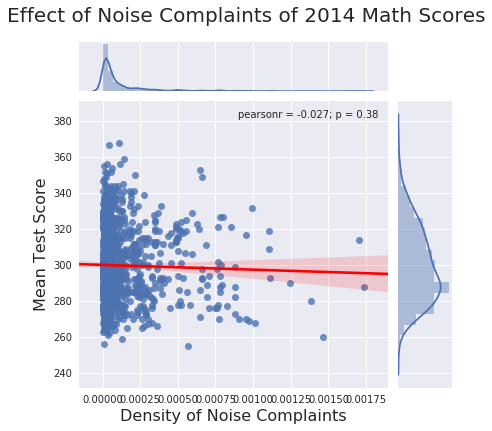

In [119]:
math2014_trend = sn.jointplot("count_vals_density", "Math2014_Mean", data =geoscores2014_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
math2014_trend.fig.suptitle('Effect of Noise Complaints of 2014 Math Scores', fontsize=20)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,0.98,'Effect of Noise Complaints of 2014 English Scores')

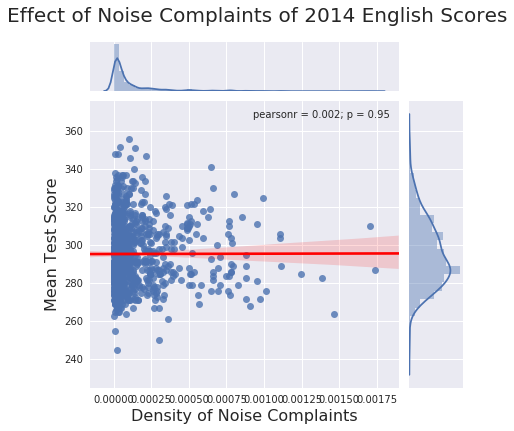

In [120]:
eng2014_trend = sn.jointplot("count_vals_density", "Eng2014_Mean", data =geoscores2014_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
eng2014_trend.fig.suptitle('Effect of Noise Complaints of 2014 English Scores', fontsize=20)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,0.98,'Effect of Noise Complaints of 2015 Math Scores')

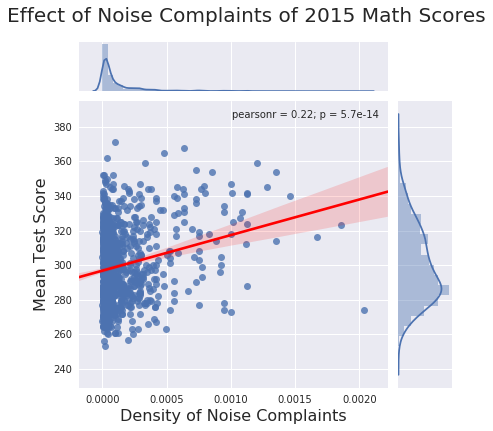

In [121]:
math2015_trend = sn.jointplot("count_vals_density", "Math2015_Mean", data =geoscores2015_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
math2015_trend.fig.suptitle('Effect of Noise Complaints of 2015 Math Scores', fontsize=20)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,0.98,'Effect of Noise Complaints of 2015 English Scores')

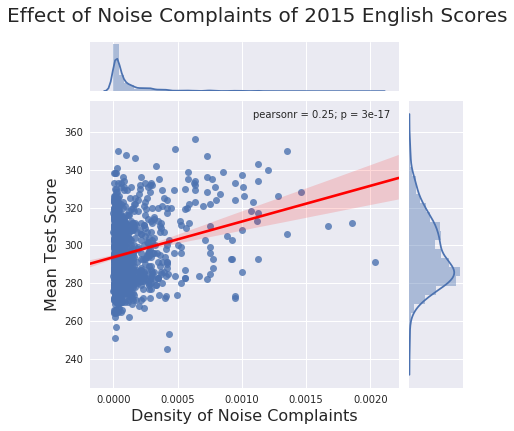

In [122]:
eng2015_trend = sn.jointplot("count_vals_density", "Eng2015_Mean", data =geoscores2015_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
eng2015_trend.fig.suptitle('Effect of Noise Complaints of 2015 English Scores', fontsize=20)

In [123]:
#save dataframes to csv
geoscores2013_final.to_csv("scores2013.csv")
geoscores2014_final.to_csv("scores2014.csv")
geoscores2015_final.to_csv("scores2015.csv")

# SECTION 3. LODES DATA MUNGING 

In [125]:
#Load data downloaded from LODES
LODES2013 = pd.read_csv("ny_rac_S000_JT00_2013.csv")
LODES2014 = pd.read_csv("ny_rac_S000_JT00_2014.csv")
LODES2015 = pd.read_csv("ny_rac_S000_JT00_2015.csv")

In [126]:
#Create the Census Tract variable for merging
LODES2013['Census Tract'] = LODES2013['h_geocode'].apply(lambda x: str(x)[5:11])
LODES2014['Census Tract'] = LODES2014['h_geocode'].apply(lambda x: str(x)[5:11])
LODES2015['Census Tract'] = LODES2015['h_geocode'].apply(lambda x: str(x)[5:11])

In [127]:
# Create aggregated Income variable for each census tract

##2013
GroupSum2013 = LODES2013.groupby(['Census Tract']).agg({'C000': sum,
                                         'CE01': sum,
                                         'CE02': sum,
                                         'CE03': sum})
GroupSum2013['ct']=GroupSum2013.index
GroupSum2013['CE01Percent'] = GroupSum2013['CE01']/GroupSum2013['C000']
GroupSum2013['CE02Percent'] = GroupSum2013['CE02']/GroupSum2013['C000']
GroupSum2013['CE03Percent'] = GroupSum2013['CE03']/GroupSum2013['C000']
GroupSum2013.columns = ['CE01totcounts', 'CE02totcounts','CE03totcounts','C000totcounts','ct','CE01Percent','CE02Percent','CE03Percent']
LODES2013merge = pd.merge(GroupSum2013, LODES2013, left_on='ct', right_on='Census Tract')

##2014
GroupSum2014 = LODES2014.groupby(['Census Tract']).agg({'C000': sum,
                                         'CE01': sum,
                                         'CE02': sum,
                                         'CE03': sum})
GroupSum2014['ct']=GroupSum2014.index
GroupSum2014['CE01Percent'] = GroupSum2014['CE01']/GroupSum2014['C000']
GroupSum2014['CE02Percent'] = GroupSum2014['CE02']/GroupSum2014['C000']
GroupSum2014['CE03Percent'] = GroupSum2014['CE03']/GroupSum2014['C000']
GroupSum2014.columns = ['CE01totcounts', 'CE02totcounts','CE03totcounts','C000totcounts','ct','CE01Percent','CE02Percent','CE03Percent']
LODES2014merge = pd.merge(GroupSum2014, LODES2014, left_on='ct', right_on='Census Tract')

##2015
GroupSum2015 = LODES2015.groupby(['Census Tract']).agg({'C000': sum,
                                         'CE01': sum,
                                         'CE02': sum,
                                         'CE03': sum})
GroupSum2015['ct']=GroupSum2015.index
GroupSum2015['CE01Percent'] = GroupSum2015['CE01']/GroupSum2015['C000']
GroupSum2015['CE02Percent'] = GroupSum2015['CE02']/GroupSum2015['C000']
GroupSum2015['CE03Percent'] = GroupSum2015['CE03']/GroupSum2015['C000']
GroupSum2015.columns = ['CE01totcounts', 'CE02totcounts','CE03totcounts','C000totcounts','ct','CE01Percent','CE02Percent','CE03Percent']
LODES2015merge = pd.merge(GroupSum2015, LODES2015, left_on='ct', right_on='Census Tract')

In [128]:
LODES2015merge.head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts,ct,CE01Percent,CE02Percent,CE03Percent,h_geocode,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,CNS04,CNS05,CNS06,CNS07,CNS08,CNS09,CNS10,CNS11,CNS12,CNS13,CNS14,CNS15,CNS16,CNS17,CNS18,CNS19,CNS20,CR01,CR02,CR03,CR04,CR05,CR07,CT01,CT02,CD01,CD02,CD03,CD04,CS01,CS02,createdate,Census Tract
0,8045,3319,15290,3926,000100,0.21707,0.256769,0.526161,360010001001008,14,3,8,3,3,9,2,0,0,0,0,2,1,1,0,0,0,0,0,0,0,2,4,0,1,1,2,10,3,1,0,0,0,14,0,1,4,3,3,6,8,20170919,000100
1,8045,3319,15290,3926,000100,0.21707,0.256769,0.526161,360010001001009,14,3,9,2,6,6,2,0,0,0,0,1,1,2,0,0,1,1,0,0,0,0,4,0,1,1,2,5,7,0,1,0,1,12,2,3,4,3,1,5,9,20170919,000100
2,8045,3319,15290,3926,000100,0.21707,0.256769,0.526161,360010001001010,16,5,8,3,3,6,7,0,0,0,2,0,0,3,1,0,1,1,1,0,0,1,2,0,0,2,2,9,6,0,1,0,0,16,0,1,6,3,1,10,6,20170919,000100
3,8045,3319,15290,3926,000100,0.21707,0.256769,0.526161,360010001001011,56,16,38,2,14,30,12,0,0,0,1,1,2,4,2,3,1,0,4,1,6,3,16,1,3,2,6,30,23,0,2,0,1,43,13,7,15,10,8,23,33,20170919,000100
4,8045,3319,15290,3926,000100,0.21707,0.256769,0.526161,360010001001012,36,12,18,6,13,14,9,0,0,0,2,0,0,2,0,0,3,1,1,2,3,3,8,1,2,1,7,11,21,0,1,1,2,33,3,3,5,11,5,18,18,20170919,000100


In [129]:
#Export to csv
LODES2013merge.to_csv("LODES2013.csv")
LODES2014merge.to_csv("LODES2014.csv")
LODES2015merge.to_csv("LODES2015.csv")

#### Create Artificial Group Labels

In [130]:
# Artificial Group Labels
# If percentage of people living in an area is >30%, then the group labels will be as follows:

# >30% in CE01 only = 'Mostly Poor'/0
GroupSum2015[(GroupSum2015['CE01Percent'] >= 0.3) & (GroupSum2015['CE02Percent'] < 0.3) & (GroupSum2015['CE03Percent'] < 0.3)].head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts,ct,CE01Percent,CE02Percent,CE03Percent
Census Tract,,,,,,,,
003802,55,190,314,69,003802,0.605096,0.219745,0.175159
053300,385,774,1642,483,053300,0.471376,0.294153,0.234470


In [131]:
# >30% in CE01 and CE02 only = 'Mid-Poor'/1
GroupSum2015[(GroupSum2015['CE01Percent'] >= 0.3) & (GroupSum2015['CE02Percent'] >= 0.3) & (GroupSum2015['CE03Percent'] < 0.3)].head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts,ct,CE01Percent,CE02Percent,CE03Percent
Census Tract,,,,,,,,
000110,293,366,1101,442,000110,0.332425,0.401453,0.266122
001701,246,344,1066,476,001701,0.322702,0.446529,0.230769
002400,1950,1985,6601,2666,002400,0.300712,0.403878,0.295410
002500,1891,2289,7311,3131,002500,0.313090,0.428259,0.258651
002502,211,266,767,290,002502,0.346806,0.378096,0.275098


In [132]:
# >30% in CE01 and CE03 only = 'Gentrified'/2
GroupSum2015[(GroupSum2015['CE01Percent'] >= 0.3) & (GroupSum2015['CE02Percent'] < 0.3) & (GroupSum2015['CE03Percent'] >= 0.3)].head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts,ct,CE01Percent,CE02Percent,CE03Percent
Census Tract,,,,,,,,
009107,914,730,2347,703,009107,0.311035,0.299531,0.389433
009109,724,504,1679,451,009109,0.300179,0.268612,0.431209
009110,206,150,481,125,009110,0.311850,0.259875,0.428274
009112,414,348,1080,318,009112,0.322222,0.294444,0.383333
011506,490,524,1439,425,011506,0.364142,0.295344,0.340514


In [133]:
# >30% in CE01 and CE02 and CE03 = 'Mixed'/3
GroupSum2015[(GroupSum2015['CE01Percent'] >= 0.3) & (GroupSum2015['CE02Percent'] >= 0.3) & (GroupSum2015['CE03Percent'] >= 0.3)].head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts,ct,CE01Percent,CE02Percent,CE03Percent
Census Tract,,,,,,,,
000104,26,26,86,34,000104,0.302326,0.395349,0.302326
000404,228,178,588,182,000404,0.302721,0.309524,0.387755
004601,542,470,1474,462,004601,0.318860,0.313433,0.367707
006102,231,243,730,256,006102,0.332877,0.350685,0.316438
006601,302,324,985,359,006601,0.328934,0.364467,0.306599


In [134]:
# >30% in CE02 only = 'Mostly Middle'/4
GroupSum2015[(GroupSum2015['CE01Percent'] < 0.3) & (GroupSum2015['CE02Percent'] >= 0.3) & (GroupSum2015['CE03Percent'] < 0.3)].head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts,ct,CE01Percent,CE02Percent,CE03Percent
Census Tract,,,,,,,,
004001,931,924,3149,1294,004001,0.293426,0.410924,0.295649
004401,981,966,3304,1357,004401,0.292373,0.410714,0.296913
008701,402,480,1662,780,008701,0.288809,0.469314,0.241877
017701,364,423,1486,699,017701,0.284657,0.470390,0.244953
017901,511,550,2008,947,017901,0.273904,0.471614,0.254482


In [135]:
# >30% in CE02 and CE03 only = 'Mid-Rich'/5
GroupSum2015[(GroupSum2015['CE01Percent'] < 0.3) & (GroupSum2015['CE02Percent'] >= 0.3) & (GroupSum2015['CE03Percent'] >= 0.3)].head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts,ct,CE01Percent,CE02Percent,CE03Percent
Census Tract,,,,,,,,
000101,686,458,1945,801,000101,0.235476,0.411825,0.352699
000103,907,608,2331,816,000103,0.260832,0.350064,0.389103
000200,4382,4028,13941,5531,000200,0.288932,0.396743,0.314325
000201,1395,974,3811,1442,000201,0.255576,0.378378,0.366046
000203,616,243,1241,382,000203,0.195810,0.307816,0.496374


In [136]:
# >30% in CE03 only = 'Mostly-Rich'/6
GroupSum2015[(GroupSum2015['CE01Percent'] < 0.3) & (GroupSum2015['CE02Percent'] < 0.3) & (GroupSum2015['CE03Percent'] >= 0.3)].head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts,ct,CE01Percent,CE02Percent,CE03Percent
Census Tract,,,,,,,,
000100,8045,3319,15290,3926,000100,0.217070,0.256769,0.526161
000202,2107,1032,4469,1330,000202,0.230924,0.297606,0.471470
000301,1394,332,2036,310,000301,0.163065,0.152259,0.684676
000502,2080,992,4229,1157,000502,0.234571,0.273587,0.491842
000700,13013,4877,23935,6045,000700,0.203760,0.252559,0.543681


In [137]:
# Attach these as a created variable
def TractLabelling(data):
    if (data['CE01Percent'] >= 0.3) & (data['CE02Percent'] < 0.3) & (data['CE03Percent'] < 0.3):
        return 0
    if (data['CE01Percent'] >= 0.3) & (data['CE02Percent'] >= 0.3) & (data['CE03Percent'] < 0.3):
        return 1
    if (data['CE01Percent'] >= 0.3) & (data['CE02Percent'] < 0.3) & (data['CE03Percent'] >= 0.3):
        return 2
    if (data['CE01Percent'] >= 0.3) & (data['CE02Percent'] >= 0.3) & (data['CE03Percent'] >= 0.3):
        return 3
    if (data['CE01Percent'] < 0.3) & (data['CE02Percent'] >= 0.3) & (data['CE03Percent'] < 0.3):
        return 4
    if (data['CE01Percent'] < 0.3) & (data['CE02Percent'] >= 0.3) & (data['CE03Percent'] >= 0.3):
        return 5
    if (data['CE01Percent'] < 0.3) & (data['CE02Percent'] < 0.3) & (data['CE03Percent'] >= 0.3):
        return 6

In [138]:
GroupSum2013['TractLabel'] = GroupSum2013.apply(TractLabelling,axis=1)
GroupSum2014['TractLabel'] = GroupSum2014.apply(TractLabelling,axis=1)
GroupSum2015['TractLabel'] = GroupSum2015.apply(TractLabelling,axis=1)

In [139]:
# Export to csv
GroupSum2013.to_csv("LODES2013Sum.csv")
GroupSum2014.to_csv("LODES2014Sum.csv")
GroupSum2015.to_csv("LODES2015Sum.csv")

#### K-MEANS Clustering

In [140]:
#standardize the features
features = ['CE01totcounts', 'CE02totcounts', 'CE03totcounts', 'C000totcounts']
x = GroupSum2013.loc[:, features].values
x = StandardScaler().fit_transform(x)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [141]:
pd.DataFrame(data = x, columns = features).head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts
0,3.044611,3.057734,3.074561,2.835156
1,-0.419329,-0.306829,-0.339897,-0.208017
2,-0.305619,-0.053239,-0.154255,0.018590
3,-0.949975,-0.988610,-1.004157,-1.003907
4,-0.676931,-0.342858,-0.515413,-0.348404


In [142]:
#PCA to 2 dimensions
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf['TractLabel'] = GroupSum2013['TractLabel'].tolist()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


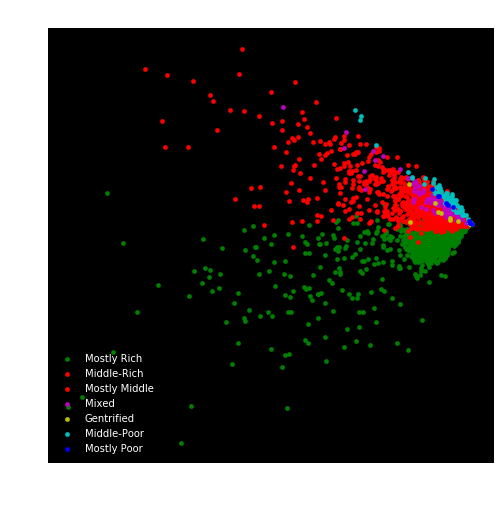

In [143]:
# Visualize with imputed labels
fig = plt.figure(figsize = (8,8))
plt.style.use('dark_background')
color = ['b', 'c', 'y', 'm', 'r','purple','g']
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)
ax.scatter(principalDf['principal component 1'][principalDf['TractLabel'] == 6]
               , principalDf['principal component 2'][principalDf['TractLabel'] == 6]
               , c = color[6]
               , s = 20
               , label = "Mostly Rich")
ax.scatter(principalDf['principal component 1'][principalDf['TractLabel'] == 5]
               , principalDf['principal component 2'][principalDf['TractLabel'] == 5]
               , c = color[4]
               , s = 20
               , label = "Middle-Rich")
ax.scatter(principalDf['principal component 1'][principalDf['TractLabel'] == 4]
               , principalDf['principal component 2'][principalDf['TractLabel'] == 4]
               , c = color[4]
               , s = 20
               , label = "Mostly Middle")
ax.scatter(principalDf['principal component 1'][principalDf['TractLabel'] == 3]
               , principalDf['principal component 2'][principalDf['TractLabel'] == 3]
               , c = color[3]
               , s = 20
               , label = "Mixed")
ax.scatter(principalDf['principal component 1'][principalDf['TractLabel'] == 2]
               , principalDf['principal component 2'][principalDf['TractLabel'] == 2]
               , c = color[2]
               , s = 20
               , label = "Gentrified")
ax.scatter(principalDf['principal component 1'][principalDf['TractLabel'] == 1]
               , principalDf['principal component 2'][principalDf['TractLabel'] == 1]
               , c = color[1]
               , s = 20
               , label = "Middle-Poor")
ax.scatter(principalDf['principal component 1'][principalDf['TractLabel'] == 0]
               , principalDf['principal component 2'][principalDf['TractLabel'] == 0]
               , c = color[0]
               , s = 20
               , label = "Mostly Poor")
ax.grid()
ax.legend(loc='lower left')

The PC are unfortunately not very well seperated, which does not bode well for the clustering algorithms. I am attempting k-means below, but with not much expectations.

For n_clusters = 2 The average silhouette_score is : 0.668355857597


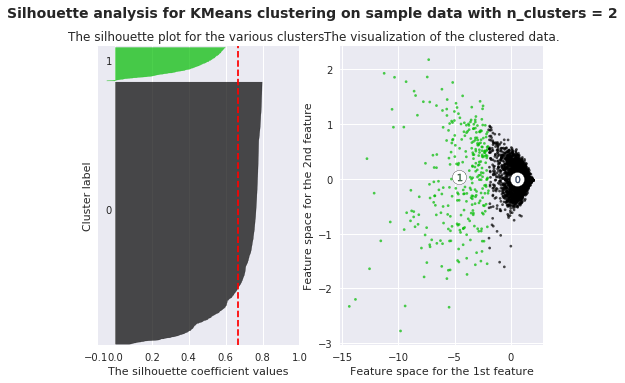

For n_clusters = 3 The average silhouette_score is : 0.611979973244


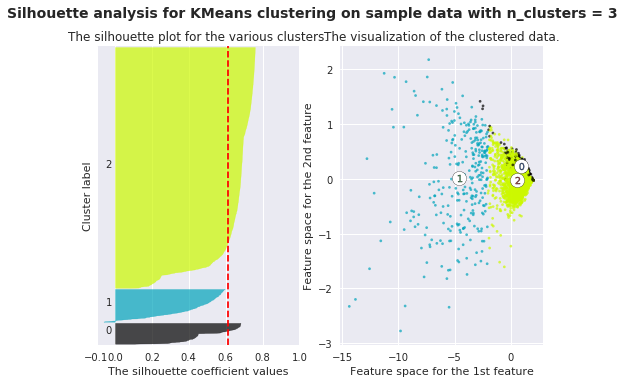

For n_clusters = 4 The average silhouette_score is : 0.568405217762


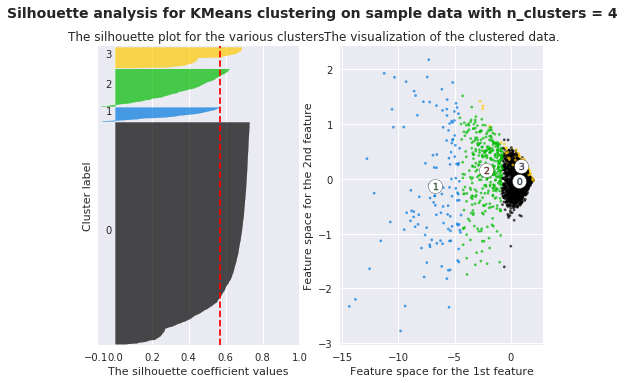

For n_clusters = 5 The average silhouette_score is : 0.437265983104


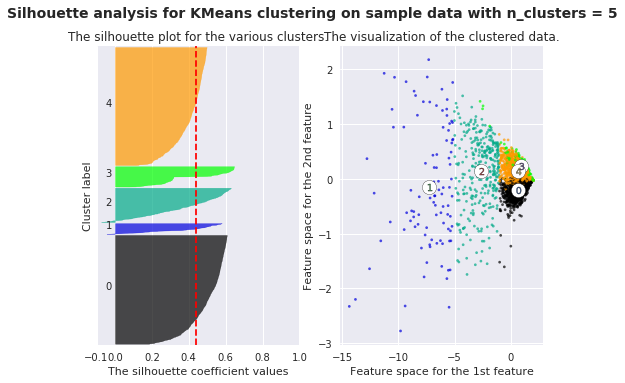

For n_clusters = 6 The average silhouette_score is : 0.458254506358


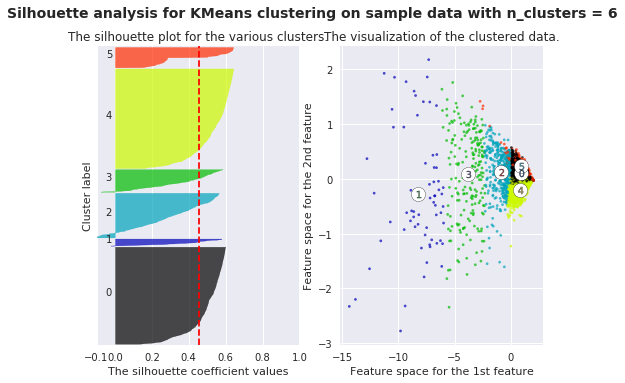

In [144]:
plt.style.use('seaborn')
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    #fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(principalDf) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(principalDf)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(principalDf, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(principalDf, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(principalDf.iloc[:, 0], principalDf.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

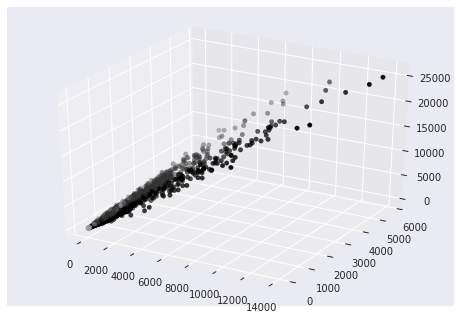

In [145]:
ax = plt.subplot(111, projection='3d')
ax.scatter3D(GroupSum2013['CE01totcounts'], GroupSum2013['CE02totcounts'], GroupSum2013['CE03totcounts'], c=GroupSum2013['TractLabel'])

# SECTION 4.  FINAL MERGE  AND MODELS

In [146]:
#read in final test scores and lodes data

scores2013 = pd.read_csv("scores2013.csv")
scores2014 = pd.read_csv("scores2014.csv")
scores2015 = pd.read_csv("scores2015.csv")

lodes2013 = pd.read_csv("LODES2013Sum.csv", converters={'Census Tract': lambda x: str(x)})
lodes2014 = pd.read_csv("LODES2014Sum.csv", converters={'Census Tract': lambda x: str(x)})
lodes2015 = pd.read_csv("LODES2015Sum.csv", converters={'Census Tract': lambda x: str(x)})

In [147]:
lodes2013.shape

(2702, 10)

In [148]:
scores2013.columns

Index(['Unnamed: 0', 'boro_ct201_x', 'count_vals', 'count_vals_density',
       'the_geom', 'BoroCode', 'BoroCT2010', 'LOCATION_NAME',
       'LOCATION_TYPE_DESCRIPTION', 'LOCATION_CATEGORY_DESCRIPTION',
       'X_COORDINATE', 'Y_COORDINATE', 'BOROUGH_BLOCK_LOT', 'DBN',
       'Number Tested', 'Eng2013_Mean', 'Math2013_Mean', 'puma',
       'boro_ct201_y', 'ct2010', 'ntaname', 'ntacode', 'boro_name',
       'shape_leng', 'shape_area', 'cdeligibil', 'boro_code', 'ctlabel',
       'geometry'],
      dtype='object')

In [149]:
#merge 
lodes_scores2013 = pd.merge(lodes2013, scores2013, left_on="ct", right_on="ct2010", how = "right")
lodes_scores2014 = pd.merge(lodes2014, scores2014, left_on="ct", right_on="ct2010", how = "right")
lodes_scores2015 = pd.merge(lodes2015, scores2015, left_on="ct", right_on="ct2010", how = "right")

In [150]:
lodes_scores2013.shape

(1043, 39)

In [151]:
lodes_scores2013.columns

Index(['Census Tract', 'CE01totcounts', 'CE02totcounts', 'CE03totcounts',
       'C000totcounts', 'ct', 'CE01Percent', 'CE02Percent', 'CE03Percent',
       'TractLabel', 'Unnamed: 0', 'boro_ct201_x', 'count_vals',
       'count_vals_density', 'the_geom', 'BoroCode', 'BoroCT2010',
       'LOCATION_NAME', 'LOCATION_TYPE_DESCRIPTION',
       'LOCATION_CATEGORY_DESCRIPTION', 'X_COORDINATE', 'Y_COORDINATE',
       'BOROUGH_BLOCK_LOT', 'DBN', 'Number Tested', 'Eng2013_Mean',
       'Math2013_Mean', 'puma', 'boro_ct201_y', 'ct2010', 'ntaname', 'ntacode',
       'boro_name', 'shape_leng', 'shape_area', 'cdeligibil', 'boro_code',
       'ctlabel', 'geometry'],
      dtype='object')

In [152]:
lodes_scores2013.head()


,Census Tract,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts,ct,CE01Percent,CE02Percent,CE03Percent,TractLabel,Unnamed: 0,boro_ct201_x,count_vals,count_vals_density,the_geom,BoroCode,BoroCT2010,LOCATION_NAME,LOCATION_TYPE_DESCRIPTION,LOCATION_CATEGORY_DESCRIPTION,X_COORDINATE,Y_COORDINATE,BOROUGH_BLOCK_LOT,DBN,Number Tested,Eng2013_Mean,Math2013_Mean,puma,boro_ct201_y,ct2010,ntaname,ntacode,boro_name,shape_leng,shape_area,cdeligibil,boro_code,ctlabel,geometry
0,000100,5720,2950,12182,3512,100,0.242161,0.288294,0.469545,6,240,3000100,42,0.000202,MULTIPOLYGON (((-73.84118263118864 40.88640783...,2,3000100,P.S. 112 Bronxwood,General Academic,Elementary,1027392.0,261724.0,2049050500,11X112,232,273,264,4004,3000100,100,Brooklyn Heights-Cobble Hill,BK09,Brooklyn,6527.277710,2.237278e+06,I,3,1.00,POLYGON ((-73.99093201741492 40.70076621604868...
1,000100,5720,2950,12182,3512,100,0.242161,0.288294,0.469545,6,340,4000100,70,0.000061,MULTIPOLYGON (((-73.98408782270893 40.63929770...,3,4000100,J.H.S. 223 The Montauk,General Academic,Junior High-Intermediate-Middle,989128.0,170661.0,3053620021,20K223,737,288,302,4109,4000100,100,Hunters Point-Sunnyside-West Maspeth,QN31,Queens,39871.986433,1.227794e+07,I,4,1.00,POLYGON ((-73.94911295133423 40.75452361982126...
2,000100,5720,2950,12182,3512,100,0.242161,0.288294,0.469545,6,341,4000100,70,0.000061,MULTIPOLYGON (((-73.98408782270893 40.63929770...,3,4000100,Urban Assembly School for Criminal Justice,General Academic,Secondary School,989128.0,170661.0,3053620021,20K609,163,300,300,4109,4000100,100,Hunters Point-Sunnyside-West Maspeth,QN31,Queens,39871.986433,1.227794e+07,I,4,1.00,POLYGON ((-73.94911295133423 40.75452361982126...
3,000201,1555,1093,4185,1537,201,0.261171,0.367264,0.371565,5,381,1000201,21,0.000233,MULTIPOLYGON (((-73.82027433015821 40.88555070...,2,1000201,P.S. 178 - Dr. Selman Waksman,General Academic,Elementary,1030803.0,257757.0,2051410150,11X178,202,296,295,3809,1000201,201,Lower East Side,MN28,Manhattan,4748.325960,9.715994e+05,E,1,2.01,POLYGON ((-73.98449647076764 40.70950966393941...
4,000201,1555,1093,4185,1537,201,0.261171,0.367264,0.371565,5,382,1000201,21,0.000233,MULTIPOLYGON (((-73.82027433015821 40.88555070...,2,1000201,M.S. 180 Dr. Daniel Hale Williams,General Academic,Junior High-Intermediate-Middle,1030803.0,257757.0,2051410150,11X180,857,298,294,3809,1000201,201,Lower East Side,MN28,Manhattan,4748.325960,9.715994e+05,E,1,2.01,POLYGON ((-73.98449647076764 40.70950966393941...


# Models using the categorical variable created 

In [153]:
MathReg2013 = smf.ols("Math2013_Mean~count_vals_density + C(TractLabel)", data=lodes_scores2013).fit()
MathReg2013.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Math2013_Mean   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.259
Date:                Wed, 25 Apr 2018   Prob (F-statistic):              0.268
Time:                        10:10:53   Log-Likelihood:                -4543.2
No. Observations:                1043   AIC:                             9102.
Df Residuals:                    1035   BIC:                             9142.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            312.1003     13.388     23.311      0.000       285.829   338.372
C(TractLabel)[T.1]   -18.3752     13.841     -1.328      0.185       -45.534     8.784
C(TractLabel)[T.2]   -35.8685     23.188     -1.547      0.122       -81.369     9.632
C(TractLabel)[T.3]   -20.5235     13.799     -1.487      0.137       -47.600     6.553
C(TractLabel)[T.4]   -14.8109     13.663     -1.084      0.279       -41.621    11.999
C(TractLabel)[T.5]   -15.7978     13.409     -1.178      0.239       -42.109    10.513
C(TractLabel)[T.6]   -13.4563     13.436     -1.002      0.317       -39.820    12.908
count_vals_density -1875.7229   3865.614     -0.485      0.628     -9461.057  5709.611
==============================================================================
Omnibus:                       46.493   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.841
Skew:                           0.541   Prob(JB):                     5.53e-12
Kurtosis:                       2.844   Cond. No.                     8.01e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [154]:
EngReg2013 = smf.ols("Eng2013_Mean~count_vals_density + C(TractLabel)", data=lodes_scores2013).fit()
EngReg2013.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Eng2013_Mean   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7285
Date:                Wed, 25 Apr 2018   Prob (F-statistic):              0.648
Time:                        10:10:53   Log-Likelihood:                -4395.2
No. Observations:                1043   AIC:                             8806.
Df Residuals:                    1035   BIC:                             8846.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            305.6009     11.616     26.308      0.000       282.806   328.395
C(TractLabel)[T.1]   -13.2547     12.009     -1.104      0.270       -36.820    10.310
C(TractLabel)[T.2]   -24.3677     20.119     -1.211      0.226       -63.847    15.112
C(TractLabel)[T.3]   -13.2112     11.973     -1.103      0.270       -36.705    10.282
C(TractLabel)[T.4]    -8.9153     11.855     -0.752      0.452       -32.177    14.347
C(TractLabel)[T.5]   -10.3332     11.634     -0.888      0.375       -33.162    12.496
C(TractLabel)[T.6]    -9.1525     11.657     -0.785      0.433       -32.028    13.722
count_vals_density -1886.7796   3354.036     -0.563      0.574     -8468.265  4694.706
==============================================================================
Omnibus:                       40.752   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.885
Skew:                           0.508   Prob(JB):                     1.79e-10
Kurtosis:                       3.019   Cond. No.                     8.01e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [155]:
MathReg2014 = smf.ols("Math2014_Mean~count_vals_density + C(TractLabel)", data=lodes_scores2014).fit()
MathReg2014.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Math2014_Mean   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.919
Date:                Wed, 25 Apr 2018   Prob (F-statistic):             0.0747
Time:                        10:10:53   Log-Likelihood:                -4805.7
No. Observations:                1086   AIC:                             9625.
Df Residuals:                    1079   BIC:                             9660.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            297.7097      5.420     54.926      0.000       287.074   308.345
C(TractLabel)[T.2]    10.8780     12.899      0.843      0.399       -14.432    36.188
C(TractLabel)[T.3]    -5.1715      8.395     -0.616      0.538       -21.643    11.300
C(TractLabel)[T.4]     0.8188      6.173      0.133      0.895       -11.294    12.932
C(TractLabel)[T.5]     1.5770      5.477      0.288      0.773        -9.169    12.323
C(TractLabel)[T.6]     5.5748      5.555      1.004      0.316        -5.325    16.474
count_vals_density -5105.8340   3105.994     -1.644      0.100     -1.12e+04   988.639
==============================================================================
Omnibus:                       41.213   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.783
Skew:                           0.425   Prob(JB):                     2.30e-09
Kurtosis:                       2.603   Cond. No.                     6.22e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [156]:
EngReg2014 = smf.ols("Eng2014_Mean~count_vals_density + C(TractLabel)", data=lodes_scores2014).fit()
EngReg2014.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Eng2014_Mean   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.555
Date:                Wed, 25 Apr 2018   Prob (F-statistic):              0.157
Time:                        10:10:53   Log-Likelihood:                -4593.7
No. Observations:                1086   AIC:                             9201.
Df Residuals:                    1079   BIC:                             9236.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            292.7860      4.459     65.660      0.000       284.036   301.535
C(TractLabel)[T.2]     9.3010     10.612      0.876      0.381       -11.521    30.123
C(TractLabel)[T.3]    -2.4045      6.906     -0.348      0.728       -15.956    11.146
C(TractLabel)[T.4]     0.3852      5.079      0.076      0.940        -9.580    10.350
C(TractLabel)[T.5]     2.1368      4.506      0.474      0.635        -6.704    10.978
C(TractLabel)[T.6]     5.0577      4.570      1.107      0.269        -3.909    14.025
count_vals_density -1745.8606   2555.239     -0.683      0.495     -6759.660  3267.939
==============================================================================
Omnibus:                       41.121   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.139
Skew:                           0.499   Prob(JB):                     1.58e-10
Kurtosis:                       3.033   Cond. No.                     6.22e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [157]:
MathReg2015 = smf.ols("Math2015_Mean~count_vals_density + C(TractLabel)", data=lodes_scores2015).fit()
MathReg2015.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Math2015_Mean   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     25.97
Date:                Wed, 25 Apr 2018   Prob (F-statistic):           5.49e-29
Time:                        10:10:53   Log-Likelihood:                -4853.7
No. Observations:                1105   AIC:                             9721.
Df Residuals:                    1098   BIC:                             9756.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            296.3360      4.626     64.052      0.000       287.258   305.414
C(TractLabel)[T.2]    -1.3418      9.251     -0.145      0.885       -19.493    16.809
C(TractLabel)[T.3]     7.6135      7.511      1.014      0.311        -7.125    22.352
C(TractLabel)[T.4]    -9.5716      5.274     -1.815      0.070       -19.919     0.776
C(TractLabel)[T.5]    -1.9801      4.691     -0.422      0.673       -11.184     7.224
C(TractLabel)[T.6]     9.5257      4.767      1.998      0.046         0.173    18.879
count_vals_density  1.356e+04   2708.467      5.007      0.000      8246.355  1.89e+04
==============================================================================
Omnibus:                       15.103   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.571
Skew:                           0.288   Prob(JB):                     0.000416
Kurtosis:                       2.920   Cond. No.                     5.59e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [158]:
EngReg2015 = smf.ols("Eng2015_Mean~count_vals_density + C(TractLabel)", data=lodes_scores2015).fit()
EngReg2015.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Eng2015_Mean   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     31.54
Date:                Wed, 25 Apr 2018   Prob (F-statistic):           4.07e-35
Time:                        10:10:53   Log-Likelihood:                -4617.9
No. Observations:                1105   AIC:                             9250.
Df Residuals:                    1098   BIC:                             9285.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            291.5933      3.737     78.020      0.000       284.260   298.927
C(TractLabel)[T.2]     2.9647      7.473      0.397      0.692       -11.698    17.628
C(TractLabel)[T.3]     7.5311      6.068      1.241      0.215        -4.375    19.437
C(TractLabel)[T.4]    -6.4864      4.260     -1.523      0.128       -14.845     1.872
C(TractLabel)[T.5]    -0.0037      3.789     -0.001      0.999        -7.439     7.432
C(TractLabel)[T.6]    10.0657      3.851      2.614      0.009         2.510    17.621
count_vals_density   1.27e+04   2187.981      5.804      0.000      8406.740   1.7e+04
==============================================================================
Omnibus:                        8.224   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.161
Skew:                           0.206   Prob(JB):                       0.0169
Kurtosis:                       3.091   Cond. No.                     5.59e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As we can see the models that use the complaint density as an explanatory variable and an "income group" as the control variable do not show great results, not only there is not consistency in the significance of the complaints variable throughout the years, but there is also a counterintuitive result on the income variable. This models should not me used

# Models using the percentage of people in the higher income group

In [165]:
MathReg12013 = smf.ols("Math2013_Mean~count_vals_density + CE03Percent", data=lodes_scores2013).fit()
MathReg12013.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Math2013_Mean   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     4.763
Date:                Wed, 25 Apr 2018   Prob (F-statistic):            0.00872
Time:                        10:15:54   Log-Likelihood:                -4542.9
No. Observations:                1043   AIC:                             9092.
Df Residuals:                    1040   BIC:                             9107.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            288.5452      2.713    106.354      0.000       283.222   293.869
count_vals_density -3282.6927   3879.321     -0.846      0.398     -1.09e+04  4329.495
CE03Percent           20.2522      6.562      3.086      0.002         7.375    33.129
==============================================================================
Omnibus:                       46.527   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.940
Skew:                           0.542   Prob(JB):                     5.26e-12
Kurtosis:                       2.854   Cond. No.                     7.19e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [171]:
MathReg12014 = smf.ols("Math2014_Mean~count_vals_density + CE03Percent", data=lodes_scores2014).fit()
MathReg12014.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Math2014_Mean   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     5.583
Date:                Wed, 25 Apr 2018   Prob (F-statistic):            0.00387
Time:                        10:16:39   Log-Likelihood:                -4805.8
No. Observations:                1086   AIC:                             9618.
Df Residuals:                    1083   BIC:                             9633.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            290.8386      2.966     98.052      0.000       285.018   296.659
count_vals_density -5565.8648   3126.956     -1.780      0.075     -1.17e+04   569.714
CE03Percent           22.6732      7.036      3.223      0.001         8.868    36.479
==============================================================================
Omnibus:                       41.777   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.790
Skew:                           0.433   Prob(JB):                     1.39e-09
Kurtosis:                       2.610   Cond. No.                     5.53e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [172]:
MathReg12015 = smf.ols("Math2015_Mean~count_vals_density + CE03Percent", data=lodes_scores2015).fit()
MathReg12015.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Math2015_Mean   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     84.09
Date:                Wed, 25 Apr 2018   Prob (F-statistic):           1.03e-34
Time:                        10:16:39   Log-Likelihood:                -4848.5
No. Observations:                1105   AIC:                             9703.
Df Residuals:                    1102   BIC:                             9718.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            268.6840      2.834     94.821      0.000       263.124   274.244
count_vals_density  1.199e+04   2717.361      4.411      0.000      6653.718  1.73e+04
CE03Percent           67.9973      6.643     10.236      0.000        54.963    81.031
==============================================================================
Omnibus:                       13.685   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.062
Skew:                           0.274   Prob(JB):                     0.000884
Kurtosis:                       2.930   Cond. No.                     5.05e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [173]:
EngReg12013 = smf.ols("Eng2013_Mean~count_vals_density + CE03Percent", data=lodes_scores2013).fit()
EngReg12013.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Eng2013_Mean   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.947
Date:                Wed, 25 Apr 2018   Prob (F-statistic):             0.0529
Time:                        10:16:40   Log-Likelihood:                -4394.8
No. Observations:                1043   AIC:                             8796.
Df Residuals:                    1040   BIC:                             8810.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            289.9230      2.354    123.167      0.000       285.304   294.542
count_vals_density -3183.5813   3365.769     -0.946      0.344     -9788.054  3420.891
CE03Percent           13.7480      5.694      2.415      0.016         2.576    24.920
==============================================================================
Omnibus:                       41.435   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.732
Skew:                           0.513   Prob(JB):                     1.17e-10
Kurtosis:                       3.015   Cond. No.                     7.19e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [174]:
EngReg12014 = smf.ols("Eng2014_Mean~count_vals_density + CE03Percent", data=lodes_scores2014).fit()
EngReg12014.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Eng2014_Mean   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     6.418
Date:                Wed, 25 Apr 2018   Prob (F-statistic):            0.00170
Time:                        10:16:40   Log-Likelihood:                -4592.0
No. Observations:                1086   AIC:                             9190.
Df Residuals:                    1083   BIC:                             9205.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            286.9870      2.436    117.815      0.000       282.207   291.767
count_vals_density -2504.1712   2567.949     -0.975      0.330     -7542.890  2534.547
CE03Percent           20.6970      5.778      3.582      0.000         9.360    32.034
==============================================================================
Omnibus:                       41.895   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.101
Skew:                           0.505   Prob(JB):                     9.76e-11
Kurtosis:                       3.025   Cond. No.                     5.53e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [175]:
EngReg12015 = smf.ols("Eng2015_Mean~count_vals_density + CE03Percent", data=lodes_scores2015).fit()
EngReg12015.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Eng2015_Mean   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     106.5
Date:                Wed, 25 Apr 2018   Prob (F-statistic):           5.33e-43
Time:                        10:16:40   Log-Likelihood:                -4608.1
No. Observations:                1105   AIC:                             9222.
Df Residuals:                    1102   BIC:                             9237.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            268.4602      2.280    117.768      0.000       263.987   272.933
count_vals_density  1.115e+04   2186.065      5.102      0.000      6863.100  1.54e+04
CE03Percent           61.0635      5.344     11.426      0.000        50.578    71.549
==============================================================================
Omnibus:                        5.925   Durbin-Watson:                   1.697
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                5.805
Skew:                           0.168   Prob(JB):                       0.0549
Kurtosis:                       3.113   Cond. No.                     5.05e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As we can see the models that use the complaint density as an explanatory variable and the number opf people in the higher income group as the control variable show relatively better results, the inconsistency in the significance and direction of the complaints variable remains, but there is a more intuitive result on the income variable, that agrees with most of the theory. This models can either be expanded to include more control variables to try to find consistency in the complaints variables or perhaps it is signaling us that there is really no correlation between the density of noise complaints in a Census Tract and the school test results obtained by the institution located in it.